# DXFPreprocessing

## ReadMe

In [ ]:
# DXF Preprocessing for CAD used to prepare electron-beam lithography files. Two seperate functionalities are included.
# Both functionalities have in notebook plotting of the final DXFs for quality assurance. 
# Checking the CAD in an external program is recommend before finally using for lithography.
#
# DXF Chip Builder
# This code allows fast definition of a matrix of devices of the same size from individual DXF files. 
# The user specifies which devices go where, and the number of rows and columns of devices.
# Label handling and alignment mark placement are also implemented.
# A template can be used instead of the alignment marks/labeling where the script just drops in the devices in a row/column format of a user made DXF.
# Note that unlike the INSERT object (aka MATRIX) in DXF which frustrates some lithography tools and can only replicate the same device,
# here the user can specify any device at any position, and can keep a copy of the generating script as a record.
# For integration with ElionixBatchExport Script, the user should surround each device with a bounding box on its own layer (usually called "matrix")
# 
# Boolean Builder
# Most CAD programs that support DXF, do not support Boolean operations for the polyline class (which is used in all of lithography). 
# All of the CAD programs that do Boolean operations for such objects, do not play well with DXF and create an import/export nightmare.
# This function is simple. With a simple python enviornment, you can take a DXF file, do any Boolean operation on any two layers,
# and get a DXF with the output of that Boolean operation as a new layer (in a DXF named "outputFilename_c.dxf")
# Support for multiple layer Boolean operations is planned, but not currently implemented.

### Import

In [24]:
import os
import sys
import datetime
import ezdxf
import numpy as np
from scipy.spatial import ConvexHull
from itertools import repeat
from ezdxf.addons import Importer
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import shapely
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('dark_background')

# DXFChip Builder

### User Defined

In [2]:
deviceDict = {}
deviceDict.update({'11': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'12': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'13': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'21': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'22': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'23': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'31': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'32': 'HB_5um_1um_EBL_TG.dxf'})
deviceDict.update({'33': 'HB_5um_1um_EBL_TG.dxf'})

bottomLabel = 'Yacoby 24/05/2020 QC2749.11'
topLabel = 'A.K.Saydjari'

template_on = 0
templateFileName = '3x3Template.dxf'
outFileName = 'test.dxf'

origin = [840, 840]
device_size_x = 700
device_size_y = device_size_x
num_rows = 3                            #max is 9, if you are writing more than 81 devices per chip, go to industry,  
num_cols = 3                            #collect more than $200 and send it to aksaydjari@gmail.com
letterSpace = 60 # um
smallLetterSpace = 20 # um

In [3]:
#Import Template (if applicable)
if template_on == 1:
    doc = ezdxf.readfile(templateFileName)
else:
    doc = ezdxf.new('R2018')
modelspace = doc.modelspace()

In [4]:
#Clean Up Empty Layers
#layerList = list(doc.layers);
#for layer in layerList:
#    q = modelspace.query('*[layer=="{}"]'.format(layer.dxf.name))
#    if len(list(q)) == 0:
#        doc.layers.remove(layer.dxf.name)

## Helper Functions

In [5]:
# Add importfile to template modelspace witha shfit
def addShifted(finaldoc, finalmsp, importfilename, shiftListxy, layerShiftInx):
    doc1 = ezdxf.readfile(importfilename)
    modelspace1 = doc1.modelspace()
    polyLineLayers = []
    polyLineColor = []
    polyLineVertices =[]
    lines = modelspace1.query('LWPOLYLINE')
    for idx, e in enumerate(lines):
        polyLineLayers.append('{}_{}'.format(e.dxf.layer,layerShiftInx))
        polyLineColor.append(doc1.layers.get(e.dxf.layer).color)
        polyLineVertices.append([])
        for j, ver in enumerate(e.vertices()):
            polyLineVertices[idx].append(tuple(list((ver[0]+shiftListxy[0],ver[1]+shiftListxy[1]))))
        polyLineVertices[idx].append(polyLineVertices[idx][0])
    for indx, layer in enumerate(polyLineLayers):
        if layer not in finaldoc.layers:
            temp = finaldoc.layers.new(name=layer)
            temp.color = polyLineColor[indx]
        temp1 = finalmsp.add_lwpolyline(polyLineVertices[indx], dxfattribs={'layer': layer})
        temp1.dxf.flags = 1

In [6]:
lookupDictLarge=dict({
    'A':'a',
    'B':'b',
    'C':'c',
    'D':'d',
    'E':'e',
    'F':'f',
    'G':'g',
    'H':'h',
    'I':'i',
    'J':'j',
    'K':'k',
    'L':'l',
    'M':'m',
    'N':'n',
    'O':'o',
    'P':'p',
    'Q':'q',
    'R':'r',
    'S':'s',
    'T':'t',
    'U':'y',
    'V':'v',
    'W':'w',
    'X':'x',
    'Y':'y',
    'Z':'z',
    'a':'aa',
    'b':'bb',
    'c':'cc',
    'd':'dd',
    'e':'ee',
    'f':'ff',
    'g':'gg',
    'h':'hh',
    'i':'ii',
    'j':'jj',
    'k':'kk',
    'l':'ll',
    'm':'mm',
    'n':'nn',
    'o':'oo',
    'p':'pp',
    'q':'qq',
    'r':'rr',
    's':'ss',
    't':'tt',
    'u':'yy',
    'v':'vv',
    'w':'ww',
    'x':'xx',
    'y':'yy',
    'z':'zz',
    '0':'0',
    '1':'1',
    '2':'2',
    '3':'3',
    '4':'4',
    '5':'5',
    '6':'6',
    '7':'7',
    '8':'8',
    '9':'9',
    
    '.':'period',
    '/':'forwardSlash',
})

lookupDictSmall=dict({
    '0':'00',
    '1':'11',
    '2':'22',
    '3':'33',
    '4':'44',
    '5':'55',
    '6':'66',
    '7':'77',
    '8':'88',
    '9':'99',
})

In [7]:
# Add shift a letter to place
def addShiftedAlignmentPointBox(finalmsp, shiftListxy, align_layer):
    box = [(shiftListxy[0],shiftListxy[1]),(shiftListxy[0]+5,shiftListxy[1]),(shiftListxy[0]+5,shiftListxy[1]+5),(shiftListxy[0],shiftListxy[1]+5),(shiftListxy[0],shiftListxy[1])]
    finalmsp.add_lwpolyline(box, dxfattribs={'layer': 'align_layer'})
def addShiftedLetter(finalmsp, string, shiftListxy):
    if string != ' ':
        for k in alphabet[lookupDictLarge[string]]:
            polyLineVertices = []
            for j, ver in enumerate(k):
                polyLineVertices.append(tuple(list((ver[0]+shiftListxy[0],ver[1]+shiftListxy[1]))))
            finalmsp.add_lwpolyline(polyLineVertices, dxfattribs={'layer': 'label'})
def addShiftedMNumber(finalmsp, string, shiftListxy):
    if string != ' ':
        for k in alphabet[lookupDictSmall[string]]:
            polyLineVertices = []
            for j, ver in enumerate(k):
                polyLineVertices.append(tuple(list((ver[0]+shiftListxy[0],ver[1]+shiftListxy[1]))))
            finalmsp.add_lwpolyline(polyLineVertices, dxfattribs={'layer': 'label'})
def addShiftedCoordObj(finalmsp, arrayObject, shiftListxy):
    for k in arrayObject:
        polyLineVertices = []
        for j, ver in enumerate(k):
            polyLineVertices.append(tuple(list((ver[0]+shiftListxy[0],ver[1]+shiftListxy[1]))))
        finalmsp.add_lwpolyline(polyLineVertices, dxfattribs={'layer': 'label'})
def addShiftedCoordRotatedObj(finalmsp, arrayObject, shiftListxy,angle):
    for k in arrayObject:
        polyLineVertices = []
        for j, ver in enumerate(k):
            rotated_coord = [ver[0]*np.cos(np.pi/180*angle)-ver[1]*np.sin(np.pi/180*angle),ver[0]*np.sin(np.pi/180*angle)+ver[1]*np.cos(np.pi/180*angle)]
            shifted_coord = [rotated_coord[0]+shiftListxy[0],rotated_coord[1]+shiftListxy[1]]
            polyLineVertices.append(tuple(list((shifted_coord[0],shifted_coord[1]))))
        finalmsp.add_lwpolyline(polyLineVertices, dxfattribs={'layer': 'label'})

In [8]:
## Stored Alphabet
#Lowercase is aa, uppercase is a, double numbers are a size smaller for matrix indexing
alphabet = {'aa': [[(30.269697815684594, 35.695595246422954),
   (29.716210132448396, 30.63670147090602),
   (29.50861431667721, 21.61161768308807),
   (30.09671617883302, 13.679268985108138),
   (32.27613306486822, 6.556337443578968),
   (33.0717861138892, 4.411362138799177),
   (33.2793819296603, 3.723356511600059),
   (32.310747243785016, 1.052250657148079),
   (30.06214662881942, 0.0),
   (27.675151778581508, 1.780730274831967),
   (25.35735850888061, 4.7351331782631405),
   (19.5109808435527, 1.5783812068250427),
   (15.290523455219002, 0.485656559193103),
   (3.493988068243212, 5.827847383685139),
   (0.0, 21.206909104864963),
   (5.742588683211508, 37.961982080447115),
   (19.5109808435527, 44.923028102248054),
   (26.258549993118308, 43.101813394724104),
   (23.625444581849408, 36.262168459965096),
   (21.413680665286805, 37.395387982491),
   (19.960733099342107, 37.75963301243496),
   (10.689551094734213, 32.61979125595303),
   (6.815030202771609, 20.842664074920094),
   (8.821483303488108, 10.886751601413152),
   (14.840824754101902, 7.56811411024205),
   (20.479633380996304, 8.984609797334087),
   (23.973621449239502, 12.0604137878031),
   (22.8666103796631, 28.12748113618204),
   (23.039592016514604, 31.891301196061022),
   (23.625444581849408, 36.25172625395703),
   (26.258549993118308, 43.09137118872013),
   (30.961570808391116, 37.63821104098315),
   (30.269697815684594, 35.695595246422954),
   (30.961570808391116, 37.63821104098315),
   (30.961570808391116, 37.63821104098315),
   (30.961570808391116, 37.63821104098315),
   (30.269697815684594, 35.695595246422954)]],
 'bb': [[(0.38057745262540266, 10.482043023182996),
   (0.17298163685430268, 23.311410419159074),
   (0.0, 36.18125180561492),
   (0.03481054610890055, 47.351300455997944),
   (0.06962109221788637, 58.60228664514989),
   (0.9344667960068023, 62.97317479346407),
   (4.082536219450105, 65.44192113770396),
   (6.677082256553177, 61.92092413632099),
   (6.504100619734402, 60.26160539073294),
   (6.331118982882799, 58.60228664514989),
   (6.227356778098482, 49.739098819268975),
   (6.1581373460284965, 39.41894131581694),
   (11.866138627658103, 42.98040186547996),
   (16.986038047129085, 44.19454848456007),
   (29.059326201507304, 37.5167995117381),
   (33.41675862591728, 22.102349154399008),
   (27.122297825819288, 22.097128051395885),
   (24.527930304334404, 32.17455647621205),
   (16.986448633043494, 36.54544462453009),
   (16.986046972898293, 36.54548639335394),
   (11.174265634951581, 34.683808137554934),
   (6.1927336733797915, 30.67716501918403),
   (6.123514241309778, 23.675645006899003),
   (6.158324787415978, 17.362141064016896),
   (6.193135333524879, 10.72486608167992),
   (10.863318200345901, 8.458479247655987),
   (15.671877450832682, 7.689483870660069),
   (23.9052321148302, 11.817548960488011),
   (27.122297825819288, 22.096083830796942),
   (33.41675862591728, 22.091906948395035),
   (28.332856881419502, 6.434915472124885),
   (15.671475790654796, 0.0),
   (15.671145536783087, 0.0),
   (6.054027035806996, 2.428272353754892),
   (3.3557009423539057, 0.48565655919105666),
   (1.1071003273854956, 1.5783707646189669),
   (0.20765829624539833, 4.2494766190700375),
   (0.2768152478765842, 7.365754600024957),
   (0.2768152478765842, 7.365754600024957),
   (0.2768152478765842, 7.365754600024957),
   (0.2768152478765842, 7.365754600024957),
   (0.2768152478765842, 7.365754600024957),
   (0.2768152478765842, 7.365754600024957),
   (0.38057745262540266, 10.482043023182996)]],
 'cc': [[(16.812663675934317, 2.088441397063434e-05),
   (4.981531961574518, 5.018451111653121),
   (0.0, 18.90006916477114),
   (4.670191792587502, 35.85750165056493),
   (16.36293819744421, 45.57059106558199),
   (23.93899834455351, 43.70891280978208),
   (29.231870475076903, 37.88106542609694),
   (28.3670247713207, 35.12902203288195),
   (26.22222206424061, 33.95535984648609),
   (24.45791647774061, 34.64336547368998),
   (23.039565239179808, 36.05986116078202),
   (16.36293819744421, 37.962002964861085),
   (9.374962060957813, 30.596248364832036),
   (6.226910489050226, 18.90006916477114),
   (9.340374659375811, 10.482063907599013),
   (16.812663675934317, 7.608608985136016),
   (21.24069010266612, 8.903693142984139),
   (25.253578452563517, 11.412903035499085),
   (26.741113420092915, 12.060424230008039),
   (28.955117707710116, 10.846288053133094),
   (29.889164992000616, 8.134718650401965),
   (24.561705459859724, 2.428282795960058),
   (16.812663675934317, 0.0),
   (16.812663675934317, 0.0),
   (16.812663675934317, 0.0),
   (16.812663675934317, 0.0),
   (16.812663675934317, 2.088441397063434e-05)]],
 'dd': [[(30.610609097319923, 0.6880056272029833),
   (27.462566451214116, 4.330414157834184),
   (22.273474377005243, 1.0927246476310302),
   (16.703858404846017, 0.0),
   (4.838130363137736, 5.5850243251941265),
   (0.0, 20.228004502716203),
   (6.114160022783835, 20.395079798831148),
   (9.266130012570102, 11.41288215108807),
   (16.703831627511136, 7.64905164900415),
   (21.616170934315107, 8.903661816365002),
   (25.456086573160007, 12.262773298019056),
   (26.459308660617296, 13.517373023175196),
   (26.35554645587132, 20.518893035459996),
   (26.39035700197752, 25.21355222323814),
   (26.459647840290927, 29.98915939198514),
   (22.965650846278606, 34.88616764776998),
   (17.74198922202322, 36.54548639335417),
   (17.741650042352433, 36.54548639335417),
   (9.02396464674979, 32.498369284500086),
   (6.114160022783835, 20.405522004838986),
   (0.0, 20.238446708720176),
   (4.8727177647197095, 37.5572735022231),
   (17.603291510219606, 44.07312651311099),
   (23.795596746116644, 42.61616727774003),
   (27.04743730014343, 39.82366033624612),
   (28.189035771301917, 62.770825725457144),
   (31.33708734317679, 66.37276026560698),
   (34.48512998931801, 62.447054685997045),
   (33.10137507810583, 37.59773705050202),
   (33.101348300770894, 37.59773705050202),
   (32.686228075469444, 25.699208782430105),
   (33.758633891892714, 5.342190824496129),
   (33.8278533239627, 4.411362138802133),
   (32.85921863808744, 1.7402562843510623),
   (32.85921863808744, 1.7402562843510623),
   (32.85921863808744, 1.7402562843510623),
   (32.85921863808744, 1.7402562843510623),
   (30.610609097319923, 0.6880056272029833)]],
 'ee': [[(9.99766025049479, 33.02449983417614),
   (5.811772412177504, 21.530680144328016),
   (16.432130852212083, 27.439465066772982),
   (25.360357571352267, 33.6253548100392),
   (30.858638701302766, 33.30164642381715),
   (26.94868245852649, 25.942031840921118),
   (19.614760899902592, 21.40925817287507),
   (6.399883200132479, 14.083977563335111),
   (11.208442450619202, 9.0250733456121),
   (17.954253221323597, 7.325280609540187),
   (23.558483372399564, 8.377531266688038),
   (28.816759175574475, 11.858064719796175),
   (31.342121483711594, 14.043503572850113),
   (33.48693311656086, 12.950778925218174),
   (34.45556780246886, 10.482032580979194),
   (28.26326256653641, 2.7520433932190826),
   (17.954253221323597, 0.0),
   (17.954253221323597, 0.0),
   (5.292881056325314, 4.573247658534001),
   (0.0, 18.738162760629166),
   (4.358842697834007, 36.38360087362207),
   (17.020223788566, 44.15407449408008),
   (26.395176923754605, 41.887687660056145),
   (30.858638701302766, 33.31208862982203),
   (25.360357571352267, 33.635797016047036),
   (17.020223788566, 36.86925743281813),
   (17.020223788566, 36.86925743281813),
   (17.020223788566, 36.86925743281813),
   (17.020223788566, 36.86925743281813),
   (9.99766025049479, 33.02449983417614)]],
 'ff': [[(25.46126352614641, 63.3778938138978),
   (16.086292539422118, 49.77957280975488),
   (15.982467854199115, 47.270362917239936),
   (23.593124328656813, 47.7560194764319),
   (29.093565497652037, 43.70889192536902),
   (26.395230478429824, 40.18790536619099),
   (23.62772065604082, 39.9855458559789),
   (15.671127685214799, 39.459415306302844),
   (15.394383843614321, 30.23198245047888),
   (15.5326888210393, 22.70434233072092),
   (15.670993798499694, 15.217176201447955),
   (14.909919225258932, 3.2376895102029266),
   (11.692674998648727, 0.0),
   (9.271092746831641, 1.0927246476319397),
   (8.267879585140633, 3.763820059878981),
   (8.33717042345154, 4.573247658530818),
   (9.063639743541898, 16.026603800103885),
   (8.95981505828604, 27.075230479039874),
   (8.95981505828604, 38.81187322737901),
   (3.4939880682431976, 38.407154206949826),
   (0.0, 42.3328597865559),
   (6.053937777997817, 46.541872857347016),
   (9.37495313519139, 46.66327394438986),
   (9.893898045713286, 52.814892367536004),
   (13.768418937678689, 66.04897878393899),
   (25.011439864113527, 71.18882054042592),
   (29.95837549830412, 67.26311496081394),
   (25.461165342568222, 63.37788337169286),
   (25.461165342568222, 63.37788337169286),
   (25.461165342568222, 63.37788337169286),
   (25.46126352614641, 63.3778938138978)]],
 'gg': [[(29.058906689793673, 3.436445926610986),
   (30.477257928354504, 16.670521900809945),
   (29.058906689793673, 3.436445926610986),
   (24.077374728219183, -6.236179940121929),
   (12.07328815437819, -10.0),
   (4.3588337719992865, -9.271499497906916),
   (0.0, -5.062486427111935),
   (3.0096751881737873, -1.4605623291688516),
   (7.160948847538691, -2.148567956372972),
   (13.595410523486919, -2.7960891508830628),
   (22.762821397544087, 4.731550968873989),
   (24.5271091324758, 19.908253179836947),
   (20.064495304123795, 13.837572295451082),
   (14.183521311409095, 11.81400851991907),
   (3.9783098740817877, 16.791964756672996),
   (0.06929083831079197, 29.783436958703078),
   (6.780585613671121, 30.346271862495996),
   (8.683089068218578, 21.527097934936137),
   (14.39107249831261, 18.572695031504054),
   (21.171497447931017, 23.186416680523052),
   (24.561696534057774, 31.604421937691995),
   (26.1184330821215, 45.32416491328809),
   (23.24712535181419, 47.185832726882154),
   (20.16826643467448, 47.792900815318035),
   (9.997642398893788, 42.49117353910401),
   (6.780585613671121, 30.356714068501105),
   (0.06929083831079197, 29.78448117930293),
   (5.431257439993715, 47.38819223709402),
   (20.514202931010004, 54.26829027792701),
   (25.91086404365251, 53.296987601748015),
   (29.23187940084341, 50.38305868880093),
   (32.933427581756405, 45.56698797177796),
   (32.20696718746791, 37.877462332294044),
   (31.27291990317741, 30.268842904954),
   (30.477257928354504, 16.670521900809945),
   (30.477257928354504, 16.670521900809945),
   (29.058906689793673, 3.436445926610986)]],
 'hh': [[(28.747441559896288, 0.0),
   (25.530197333253454, 3.0758144326759975),
   (24.077249767305943, 12.505606798717054),
   (23.45454265199976, 22.137748232765034),
   (23.523833490346078, 25.334974194687902),
   (23.627658175569195, 28.53218971440606),
   (20.37581762154241, 36.14077781512697),
   (12.523004707066207, 31.486592617837005),
   (7.679849129192803, 22.380571291256047),
   (6.572846985418437, 4.12806508982294),
   (3.563180722978359, 1.6188447550998717),
   (1.0724236679943715, 2.75204339321499),
   (0.0, 5.504086786430889),
   (0.3113580205553035, 7.284817061261947),
   (0.691864066937228, 13.193612425915944),
   (0.7956262716860465, 19.18334532933295),
   (0.8994509569420188, 48.929681662822986),
   (1.1415895453919802, 55.68836817440797),
   (0.7956262716860465, 59.57359976353496),
   (0.4842682511333578, 63.41836780437802),
   (1.4875081901918747, 66.21087474587193),
   (3.9436778435937185, 67.34407338398887),
   (7.264693200787406, 63.78260239211704),
   (7.818180883990749, 56.70014484107196),
   (7.576042295540901, 47.836957015191956),
   (7.402998178212215, 38.973758747105876),
   (7.437808724321258, 35.41229819744399),
   (13.491737576552623, 42.049573179785966),
   (20.375924730919905, 44.27548602332399),
   (28.263351824351048, 39.90459787500595),
   (29.99304323189608, 29.54397682327408),
   (30.269787073531802, 21.813977193306073),
   (30.96167791780408, 13.39596149392787),
   (32.13786379054454, 5.058904217723011),
   (32.27616876800482, 3.8852315891228955),
   (31.23836820473207, 1.133198638111935),
   (28.74759329814424, 0.0),
   (28.74759329814424, 0.0),
   (28.74759329814424, 0.0),
   (28.74759329814424, 0.0),
   (28.747441559896288, 0.0)]],
 'ii': [[(6.780353543380329, 18.576277240896843),
   (6.884187154402753, 11.29146017963103),
   (7.022492131830404, 4.047117108853854),
   (6.0884448475371755, 1.133188195906996),
   (3.6322841199371396, 0.0),
   (1.1761144664995982, 1.133188195906996),
   (0.24206718220909806, 4.047117108853854),
   (0.10376220478156029, 11.29146017963103),
   (0.0, 18.576277240896843),
   (0.34596327370582003, 28.046533155212956),
   (0.6919265474115264, 37.557273502219005),
   (1.6259470543318457, 40.51166596344592),
   (4.082125633535725, 41.64485415935701),
   (6.503707885355652, 40.51166596344592),
   (7.472324719662538, 37.557273502219005),
   (7.12636144598946, 28.046533155212956),
   (6.780398172286368, 18.576277240896843),
   (6.780398172286368, 18.576277240896843),
   (6.780398172286368, 18.576277240896843),
   (6.780353543380329, 18.576277240896843)],
  [(2.3523360424123894, 52.81491325194497),
   (1.141544916485941, 56.13355074311585),
   (2.3523360424123894, 59.45218823428786),
   (5.223616995349403, 60.8282099308949),
   (8.060337324041939, 59.45218823428786),
   (9.27111059836443, 56.13355074311585),
   (8.060337324041939, 52.81491325194497),
   (5.223616995349403, 51.43889155533793),
   (5.223616995349403, 51.43889155533793),
   (5.223616995349403, 51.43889155533793),
   (2.3523360424123894, 52.81491325194497)]],
 'jj': [[(16.501296729577007, 4.771993632734848),
   (15.325110856833817, 29.014232737589964),
   (14.148907132492127, 51.31386649008596),
   (15.117541818400241, 54.91580103023284),
   (17.64289520073544, 56.494182237056975),
   (19.995293723622012, 55.48239512818782),
   (21.240672251097635, 53.418367804377795),
   (22.382261796487, 30.106957385221904),
   (23.31630908078023, 5.176702210962958),
   (20.44500135050555, -5.022043763246984),
   (12.868941203399118, -10.0),
   (0.41512022530150716, 3.3959719361319003),
   (0.0, 5.338587730694826),
   (1.072423667991643, 8.131094672184872),
   (3.5631807229782453, 9.304767300785898),
   (7.818252290228884, 4.04350357284693),
   (9.755512736245691, 0.07733444496079755),
   (12.86895905496749, -1.9462293305700769),
   (15.46349616630414, 0.7248660816758274),
   (16.50131458114538, 4.771993632734848),
   (16.50131458114538, 4.771993632734848),
   (16.50131458114538, 4.771993632734848),
   (16.501296729577007, 4.771993632734848)],
  [(13.906750692473906, 66.73339175954084),
   (12.73054696816223, 70.01155526022694),
   (13.906750692473906, 73.33019275139782),
   (16.778040571177257, 74.70621444800486),
   (19.649339375682757, 73.33019275139782),
   (20.86013942737827, 70.01155526022694),
   (19.649339375682757, 66.73339175954084),
   (16.778040571177257, 65.3573700629338),
   (16.778040571177257, 65.3573700629338),
   (16.778040571177257, 65.3573700629338),
   (13.906750692473906, 66.73339175954084)]],
 'kk': [[(27.98647409603302, 0.0),
   (25.045982636792473, 2.347324372785806),
   (19.61474304833439, 12.019939797319012),
   (13.49161261560414, 21.773492760615),
   (7.264702126553971, 16.55271346536597),
   (6.884187154405481, 4.330414157828955),
   (5.915552468494866, 1.3760112544030108),
   (3.4939969940479614, 0.24281261628493667),
   (0.0, 5.7469098449259945),
   (0.3805060463847667, 15.783759857196856),
   (0.7956173459198226, 25.86109430215788),
   (0.9339223233801022, 39.90459787500981),
   (1.1069753664725113, 53.90762745737197),
   (0.9339223233801022, 58.19757806692701),
   (0.7956173459198226, 62.48751823427688),
   (1.7296467786419498, 65.44192113770282),
   (4.185816432043794, 66.57510933361482),
   (6.607398683863835, 65.44192113770282),
   (7.576024443972642, 62.48751823427688),
   (7.749068561298486, 58.076166537677864),
   (7.92212160439351, 53.70526794715602),
   (7.679983015907965, 40.67354104097194),
   (7.576158330687576, 26.589573919842906),
   (16.639771296856566, 35.81700677566687),
   (24.250445622918164, 45.00396564101197),
   (26.7066063505182, 46.37998733761401),
   (29.128179676571676, 45.12537717025498),
   (30.235190746148078, 42.21144825730789),
   (29.23197758445724, 39.49987885457699),
   (18.750004453925612, 26.994282498064877),
   (26.29148612521658, 14.974342700750867),
   (31.58435825573997, 3.966179570094937),
   (30.477347186166412, 1.1736621863919936),
   (27.986581205413245, 0.0),
   (27.986581205413245, 0.0),
   (27.986581205413245, 0.0),
   (27.98647409603302, 0.0)]],
 'll': [[(7.57631899477019, 33.55061994164407),
   (7.057499045158579, 13.43643548441105),
   (6.780362469179636, 4.0471275510640226),
   (3.3902080119260063, 0.0),
   (0.0, 4.12806508982294),
   (0.38023827295182855, 18.81911074159393),
   (0.7604765459063856, 33.55061994164407),
   (0.9338598429030753, 48.16072805465501),
   (1.10657370632714, 62.81129971594305),
   (4.496781718253146, 66.858416824796),
   (7.921541428624437, 62.81129971594305),
   (7.748827565203101, 48.16072805465501),
   (7.576113701778922, 33.55061994164407),
   (7.576113701778922, 33.55061994164407),
   (7.576113701778922, 33.55061994164407),
   (7.57631899477019, 33.55061994164407)]],
 'mm': [[(44.55582990615039, 1.6593187455880525),
   (41.23483240052792, 5.180315746970109),
   (39.98948065038701, 17.726375651761145),
   (38.81322337137033, 30.27244599875212),
   (37.63702857282806, 35.7360587947021),
   (35.0771145662128, 39.37846732533308),
   (30.30317842044508, 36.82878344233018),
   (25.944300019506954, 33.064963382452106),
   (26.11768331650353, 25.456375281731198),
   (27.155501731344884, 14.650571661290087),
   (27.812885506080306, 4.087591099338169),
   (26.844215117065687, 1.1736621863951768),
   (24.42260608791082, 0.0),
   (21.966454286044495, 1.1736621863951768),
   (21.032460556459114, 4.087591099338169),
   (20.16762377843679, 18.53580325041321),
   (19.33732084735675, 33.0244893919712),
   (18.299502432515396, 39.702238364793175),
   (13.387198828815599, 35.493235736207),
   (9.305126749984993, 30.151034469509113),
   (7.540767608812416, 27.601350586505077),
   (7.160529335860701, 20.437955496697214),
   (6.780291062906031, 13.43643548441105),
   (7.091577677220812, 10.036850012271088),
   (7.43767483760621, 6.880108483038157),
   (6.365304724319685, 4.087591099338169),
   (3.9090904420116885, 2.954392461226007),
   (0.0, 13.35549794564713),
   (0.38023827295455703, 20.59984101642908),
   (0.7604765459063856, 27.84418408720603),
   (0.41437938548551756, 34.279099559331144),
   (0.10309277120893512, 40.754489021941026),
   (3.631677166800614, 49.94144788728113),
   (6.087828968669783, 48.56543663287812),
   (7.229480994500591, 45.570559738963084),
   (7.056767131076299, 43.182761375696145),
   (6.8840532676903194, 40.714025473662105),
   (6.953674359905563, 36.46454885459002),
   (12.246546490428841, 44.27548602332399),
   (18.196677434774756, 47.79648302471105),
   (25.66895752553137, 41.482968639624005),
   (30.20075508284947, 45.89433077842705),
   (36.22010545922967, 47.391764004282095),
   (44.10756825579483, 40.106957385220994),
   (45.52590164278706, 28.734549224622015),
   (48.01665869777389, 5.544550334709129),
   (47.0826024877141, 2.792517383699078),
   (44.55729373424947, 1.6593187455880525),
   (44.55709736706001, 1.6593187455880525),
   (44.55709736706001, 1.6593187455880525),
   (44.55709736706001, 1.6593187455880525),
   (44.55582990615039, 1.6593187455880525)]],
 'nn': [[(27.052748139844994, 0.0),
   (23.697145381069276, 3.804294050363069),
   (22.728537472531684, 12.667492318448922),
   (22.24386756125307, 21.530680144328926),
   (22.347629766001887, 25.375448185176083),
   (22.486202516892376, 29.22020578381398),
   (19.718701620272668, 37.96199252265092),
   (12.315569555345292, 32.579317265468944),
   (7.334037593770631, 20.195132438205974),
   (7.022759905260614, 16.228952868111037),
   (6.815235495730235, 12.303247288504053),
   (7.022759905260614, 8.66083875787308),
   (7.2302843147909925, 5.018430227242106),
   (6.261676406253287, 2.0640377660160993),
   (3.8400673770958065, 0.930839127903937),
   (1.3839155752622219, 2.0640377660160993),
   (0.4498593651696865, 5.018430227242106),
   (0.20752440953037876, 8.66083875787308),
   (0.0, 12.303247288504053),
   (0.4846699112786155, 23.837540968836947),
   (1.0034809351209333, 35.412298197446944),
   (0.8649081842305577, 39.25706623829001),
   (0.7611459794816255, 43.101834279138075),
   (1.729744962220252, 45.934815211116984),
   (4.1858967640865785, 47.06800340702807),
   (7.679875906563325, 41.806750121293135),
   (7.783638111312143, 37.07161694303113),
   (19.718567733557506, 46.137164279123),
   (27.43298641279671, 40.430728424686095),
   (29.058906689793844, 29.17974223553506),
   (29.058906689793844, 25.09214069399104),
   (29.02543501083801, 21.32832063411297),
   (29.751904330925868, 12.627018327963924),
   (30.512978904134002, 4.0066535605799345),
   (29.509765742443165, 1.1331986381160277),
   (27.05361394060958, 0.0),
   (27.05361394060958, 0.0),
   (27.05361394060958, 0.0),
   (27.052748139844994, 0.0)]],
 'oo': [[(27.91732607020367, 36.94891058024086),
   (17.43539756857524, 44.35513917074604),
   (27.91732607020367, 36.94891058024086),
   (30.65029311991384, 22.54116197744588),
   (26.637369066879728, 7.202584688955994),
   (14.917863170426244, 0.0),
   (14.917863170426244, 8.169981980089005),
   (21.102358347906375, 11.249701797810985),
   (24.215822518196546, 20.43666066315086),
   (16.985672090123444, 36.13948298158493),
   (9.063666520876723, 30.473521117626888),
   (6.815039128573403, 20.03194164272304),
   (9.54793477204305, 10.885456767867026),
   (14.908937389347443, 8.169981980089005),
   (14.908937389347443, 0.0),
   (4.912375009943389, 5.01713539369689),
   (0.0, 20.03194164272304),
   (3.943776027207605, 36.13948298158493),
   (17.43539756857524, 44.35513917074604),
   (17.43539756857524, 44.35513917074604),
   (27.91732607020367, 36.94891058024086)]],
 'pp': [[(6.74560547771182, -8.866811804089139),
   (4.324067854797818, -10.0),
   (1.867853572489821, -8.866811804089139),
   (0.9338598428703335, -5.952882891146146),
   (1.0376220476518938, 10.235595986484896),
   (1.0376220476518938, 26.383611315832013),
   (0.5188110238096897, 42.53161620296896),
   (0.0, 50.74726194992604),
   (0.8994509569080265, 55.603806657435825),
   (3.909152922450744, 57.99160502070686),
   (6.157717834315008, 56.858416824801),
   (7.091774044373437, 54.146847422064866),
   (6.988011839625983, 52.811299715941914),
   (6.745676883952569, 50.50443889143503),
   (12.488283418732522, 54.06589944109692),
   (17.781155549291498, 55.280035617975955),
   (28.159321846136777, 47.914281017951),
   (30.753885734809614, 32.50662853672293),
   (23.97029213292899, 32.50662853672293),
   (22.416849198071873, 43.502918879147956),
   (17.781155549291498, 47.18580140026802),
   (12.038557940279134, 45.526482654680876),
   (7.402998178212329, 41.23653204512584),
   (7.852857543382015, 21.931775186544883),
   (15.39429458576842, 20.231982450476835),
   (22.001737898536817, 23.995802510356043),
   (23.97029213292899, 32.49618633071805),
   (30.753885734809614, 32.49618633071805),
   (26.740988459144432, 18.087007145697953),
   (15.394160699053486, 12.09726380007396),
   (15.393883999856826, 12.09726380007396),
   (7.783236451165521, 13.392347957923903),
   (7.714275866723824, -5.952882891146146),
   (7.714275866723824, -5.952882891146146),
   (7.714275866723824, -5.952882891146146),
   (7.714275866723824, -5.952882891146146),
   (6.74560547771182, -8.866811804089139)]],
 'qq': [[(27.118040228270047, 55.32050960846004),
   (29.505035078507035, 54.02543589281686),
   (30.54286241911609, 51.07103298938591),
   (29.366667620573935, 25.250423119920015),
   (29.365998186997103, 25.250423119920015),
   (27.774692088918982, 9.709475879007869),
   (26.909846385163064, -5.9528724489421165),
   (25.97585265554403, -8.866801361883972),
   (23.519638373237058, -10.0),
   (20.129421435507993, -5.912408900662058),
   (20.302804732506047, -1.4200987808910668),
   (20.752664097710067, 3.0722008966708927),
   (21.410047872408086, 12.016336703517027),
   (17.224151108322985, 11.08548713340997),
   (5.0125401249511015, 15.658734791941015),
   (0.0, 29.20800875447003),
   (6.917480317704985, 29.04093345835099),
   (9.405827411818109, 21.28424354982394),
   (16.981950039398953, 18.127481136180904),
   (21.790491438319123, 22.29602021648884),
   (23.554779173249017, 37.715545485946905),
   (24.03944908452513, 48.52134910638597),
   (21.617840055370152, 48.39994801934699),
   (19.161688253537022, 48.52134910638597),
   (19.161357999631946, 48.52134910638597),
   (9.544275201794107, 40.95323499614801),
   (6.917480317704985, 29.051375664359966),
   (0.0, 29.21845096047491),
   (5.704395266086067, 48.23805205741087),
   (21.61763476241299, 55.522869118671906),
   (24.48890678955013, 53.78260239212091),
   (24.48890678955013, 53.78260239212091),
   (24.48890678955013, 53.78260239212091),
   (27.118040228270047, 55.32050960846004)]],
 'rr': [[(26.914309275701953, 32.61979125595303),
   (23.454881831705052, 27.56088703822593),
   (20.479776193511952, 31.567540598805863),
   (20.37602291453095, 34.400521530785),
   (20.27225178398203, 37.80010700291882),
   (11.520014689900108, 34.198162020567),
   (6.400115270426113, 26.265813322586837),
   (6.469066929101018, 4.087591099338852),
   (3.0443161444970883, 0.0),
   (0.0, 4.087591099338852),
   (0.0, 32.498379726705025),
   (0.06895165867399555, 36.50502284507502),
   (0.1727138634221319, 40.511676405653816),
   (3.217030007918993, 44.599267504992895),
   (6.64178079252315, 37.88104454168183),
   (21.378825490308145, 45.36821067095593),
   (25.564668699688127, 42.89947476892098),
   (26.94845038823496, 35.45277218792785),
   (26.914978709278103, 32.61979125595303),
   (26.914978709278103, 32.61979125595303),
   (26.914978709278103, 32.61979125595303),
   (26.914309275701953, 32.61979125595303)]],
 'ss': [[(26.741122345858912, 33.591104374336965),
   (24.077374728253062, 35.08853760019201),
   (23.17793269707795, 39.459425748506874),
   (15.186698769997065, 36.626434374323026),
   (9.582540025159005, 30.231992892682),
   (11.623571601691083, 29.58445081375794),
   (23.45467653871401, 25.011203155226895),
   (29.093511942943906, 12.707955866727843),
   (24.2157511119201, 2.75204339321499),
   (13.975961198776076, 0.0),
   (5.327477383674932, 1.780740717039862),
   (0.0, 8.094244659917877),
   (1.0724236679920978, 10.927225591897013),
   (3.563189648778007, 12.141361768775823),
   (6.330699471166099, 10.198745974207895),
   (10.066808276324991, 8.660838757872853),
   (13.975961198776076, 8.175203083090992),
   (19.095860618248935, 8.98462023953789),
   (22.31308699332294, 12.707976751136812),
   (15.740257859474013, 20.154679332130854),
   (12.142445106007017, 21.085518460030926),
   (5.60423015107699, 23.837561853245916),
   (2.8021150755380404, 30.677196345804987),
   (9.61708279783602, 42.73761013360695),
   (16.25913136375607, 45.32776800709098),
   (22.797426650728994, 47.91791543836894),
   (25.87628556786899, 48.646405498261856),
   (28.2978231907839, 47.51320686014492),
   (29.266493579797043, 44.55881439891891),
   (29.68154239885689, 41.118765378503895),
   (30.131401764027032, 37.67870591588098),
   (29.16273137501389, 34.72431345465884),
   (26.74119375209989, 33.591114816541904),
   (26.74119375209989, 33.591114816541904),
   (26.74119375209989, 33.591114816541904),
   (26.741122345858912, 33.591104374336965)]],
 'tt': [[(25.70544611849391, 37.071616943030904),
   (23.97576363671601, 37.15255448179391),
   (22.280686408088968, 37.23349202055397),
   (17.575916139719993, 36.626423932118996),
   (18.233290988652016, 12.707955866723069),
   (18.266762667607964, 10.927215149687981),
   (18.30023434656505, 8.863177383675065),
   (14.66788774618908, 0.0),
   (12.246287642801008, 1.0522402149420031),
   (11.243074481109943, 3.682872078909895),
   (11.346827760090946, 8.296583285720999),
   (11.450598890639867, 12.910304934734995),
   (10.75873482370298, 36.54547595114991),
   (3.078858917175012, 37.23349202055397),
   (0.0, 41.24014558113299),
   (0.9340562100928764, 44.19453804235491),
   (3.3209975056240637, 45.36820022874599),
   (10.58575318685007, 44.68019460154687),
   (10.413039323462954, 50.184270945771914),
   (10.27446657257201, 55.202701173011064),
   (11.277742214736008, 57.995208114504976),
   (13.733894016570048, 59.12840675262191),
   (17.36624061694488, 53.179137397484055),
   (17.470002821726894, 49.57720285733308),
   (17.401051163087004, 47.22987848454591),
   (17.367579484131056, 44.72065814982602),
   (22.279954494038975, 45.36820022874599),
   (26.98473368820987, 44.963491650526976),
   (29.09492221637197, 41.15919760016095),
   (28.126314307834036, 38.20479469673296),
   (25.70470527864404, 37.07160650082096),
   (25.70470527864404, 37.07160650082096),
   (25.70470527864404, 37.07160650082096),
   (25.70544611849391, 37.071616943030904)]],
 'uu': [[(29.26856436099797, 26.8728709688221),
   (29.302036039955055, 18.131094672190102),
   (29.335507718911003, 9.389318375556968),
   (29.439269923694155, 6.677748972825157),
   (29.5778426745851, 3.966179570094937),
   (28.5745670324211, 1.1331986381160277),
   (26.118415230552955, 0.0),
   (22.72820721862604, 3.8447680408469296),
   (12.765161147082154, 1.214136176879947),
   (5.258266877407095, 3.5614605496621152),
   (1.3491764353950657, 11.129574659903028),
   (0.0, 30.231982450477062),
   (1.0378184148410128, 42.85900077843803),
   (4.324273147787153, 46.37998733761901),
   (6.8150302027729595, 45.24679914170815),
   (7.818243364461978, 42.41380776752408),
   (7.299432340653084, 36.46454885459502),
   (6.815431862918103, 30.231982450477062),
   (7.195670135871069, 18.657225221866156),
   (8.33725968126214, 10.927215149687072),
   (10.585887073565118, 9.794026953780076),
   (12.765295033796974, 9.429781923836117),
   (22.555359468522056, 11.170038208183087),
   (22.521887789566108, 19.38569439734397),
   (22.452936130890976, 27.23710555656112),
   (23.110319905625147, 42.41380776752408),
   (26.46592266440007, 46.13715383691806),
   (28.956679719384056, 45.003965641011064),
   (29.890744855246112, 42.170974266828125),
   (29.890744855246112, 42.170974266828125),
   (29.890744855246112, 42.170974266828125),
   (29.26856436099797, 26.8728709688221)]],
 'vv': [[(18.611538812412704, 3.7233565116009686),
   (15.463487240502303, 0.0),
   (11.796535386975904, 3.4805230109038803),
   (6.503663256449798, 19.911835389227008),
   (0.34593649633559664, 38.48810218791891),
   (0.0, 40.34979088592286),
   (1.0724147421925068, 43.18276137569683),
   (3.5631807229784016, 44.35642356208791),
   (6.5382506580344995, 41.88767721784893),
   (15.325110856801103, 13.598321004143827),
   (21.863370440637496, 32.37695775525299),
   (24.803852974076108, 41.523442630109),
   (27.848115563864695, 44.1136005035969),
   (30.338881544653404, 42.93994875941098),
   (31.411296286878596, 40.147420933500825),
   (25.703295005249004, 22.825764302173866),
   (25.703295005249004, 22.825764302173866),
   (25.703295005249004, 22.825764302173866),
   (18.611538812412704, 3.7233565116009686)]],
 'ww': [[(43.5883734233403, 39.49988929678193),
   (36.53120463211869, 9.672615424532978),
   (33.313969331277804, 2.104490872086899),
   (30.02754137566629, 0.0),
   (24.14657630875351, 10.967699582377008),
   (22.728225070192792, 20.437955496697896),
   (21.586626599001704, 29.463039284514934),
   (18.749924121880184, 21.733029212336987),
   (13.491648318705302, 5.018419785033984),
   (12.177068210692596, 2.6710954122479507),
   (8.856052853501694, 0.24283350070095366),
   (3.7707497614119063, 12.30324728849996),
   (1.2799837806259973, 29.301143322574035),
   (0.44972547845191, 35.3718242069599),
   (0.0, 41.482968639624914),
   (1.0032220874572886, 44.27549646552984),
   (3.4939880682431976, 45.4086742192319),
   (6.745819696468089, 42.04957317978506),
   (7.472289016523092, 36.140788257336),
   (7.991171446608888, 30.191508459992974),
   (10.032211948940102, 12.019939797319921),
   (17.988822771301784, 40.754489021941026),
   (21.967123719617092, 45.246799141708834),
   (25.6686719005302, 40.22836891446991),
   (27.917281441262304, 25.658734791942834),
   (30.37345109466699, 9.753552963295988),
   (32.898813402836794, 20.761716093951918),
   (37.3614272311888, 42.818516345749),
   (40.336506092011405, 45.28727313219292),
   (42.861868400148495, 44.1136005035919),
   (43.934274216571794, 41.361567552581846),
   (43.58831094289869, 39.49988929678193),
   (43.58831094289869, 39.49988929678193),
   (43.58831094289869, 39.49988929678193),
   (43.58831094289869, 39.49988929678193),
   (43.5883734233403, 39.49988929678193)]],
 'xx': [[(29.4394484393124, 30.96045162595601),
   (23.2817216791982, 23.797056536143145),
   (34.5593478587862, 6.55632700137312),
   (35.424193562542285, 4.006643118369084),
   (34.386384073503024, 1.2141257346700058),
   (32.033985550616336, 0.0),
   (29.646999626180417, 1.4974227836460159),
   (18.438575027126717, 18.171568662673963),
   (11.692764256425107, 10.036860454476937),
   (5.742597609010801, 3.359101039446159),
   (3.3556027587756034, 1.9021209196639575),
   (1.0032310132592102, 3.1162675387481613),
   (0.0, 5.908784922449058),
   (0.8648457037889159, 8.458468805448092),
   (3.874520891962703, 12.06041378780401),
   (7.022572463870404, 15.459978375527953),
   (14.391081424079005, 24.48506216334613),
   (9.859283866793703, 32.134124254552034),
   (5.085312017889009, 38.81186278516816),
   (3.770740835645512, 41.8067396790841),
   (4.739366595751619, 44.68019460154801),
   (7.022572463870404, 45.934794326702104),
   (13.180290298185412, 39.70222792258801),
   (19.165053272983698, 30.02961249805594),
   (25.94545144526731, 37.314440001522144),
   (31.653461652698837, 44.599246620578015),
   (34.28259509138391, 46.50139886686202),
   (36.66958101581989, 45.32774712267701),
   (37.70739943066113, 42.616156835531),
   (34.49015520401829, 36.50500196066514),
   (34.49015520401829, 36.50500196066514),
   (34.49015520401829, 36.50500196066514),
   (29.4394484393124, 30.96045162595601)]],
 'yy': [[(23.143327443961482, 19.26066933208881),
   (16.362929271675114, 0.7653296299549766),
   (14.07971447775708, -7.086081529261037),
   (10.966259233233416, -10.0),
   (8.440905850862805, -8.86682224629817),
   (7.403087436021508, -6.114757968672166),
   (14.875376452580099, 17.318043095320945),
   (2.4907570549839875, 45.202701173011974),
   (0.9340205069557328, 48.15709363423798),
   (0.0, 51.27338205739784),
   (1.072387964855011, 54.187310970344924),
   (3.5285576182895966, 55.44192113770487),
   (5.984736197460791, 54.02541500840789),
   (18.611529886643496, 26.82877300012592),
   (23.731420380315285, 40.79134947641796),
   (29.058906689791, 53.25647184244599),
   (31.964783970114695, 55.52285867646788),
   (34.45554995090072, 54.34918604786799),
   (35.562552094675084, 51.55668954857879),
   (35.1128266162205, 49.53312577305087),
   (35.1128266162205, 49.53312577305087),
   (35.1128266162205, 49.53312577305087),
   (23.143327443961482, 19.26066933208881)]],
 'zz': [[(29.1281082702954, 35.857543419389),
   (21.24068117686687, 23.311473072394165),
   (13.0765191676374, 9.794100049220106),
   (19.407191861433603, 9.996323810757985),
   (23.42010698866858, 9.389287048937149),
   (27.43298641279671, 8.782260729326026),
   (29.889164991967903, 7.608588100725001),
   (30.857799677843104, 4.694659187778143),
   (29.889164991967903, 1.7402667265521359),
   (27.43298641279671, 0.6070576462350346),
   (23.42010698866858, 1.2140944080510963),
   (19.407191861433603, 1.8211207276660843),
   (4.635586539404358, 0.16180198208417096),
   (3.3556027587428616, 0.0),
   (0.0, 3.4400594626231396),
   (1.729700333314156, 7.325301493955976),
   (21.379066486369993, 37.0716378274401),
   (14.702421593065992, 36.74786678798114),
   (4.185861060949662, 37.67871635808615),
   (1.10700214377448, 41.685349034250066),
   (2.0410494280677085, 44.63974149547698),
   (4.3934300993859665, 45.853888114558),
   (9.513347370428164, 45.368241997570976),
   (14.702421593065992, 44.92301766003902),
   (21.759590384287492, 45.287262689987074),
   (28.81675024974271, 45.69200259483),
   (31.757232783213965, 42.85901122064206),
   (29.1281082702954, 35.857491208361125),
   (29.1281082702954, 35.857491208361125),
   (29.1281082702954, 35.857491208361125),
   (29.1281082702954, 35.857543419389)]],
 'a': [[(6.572846985418494, 2.549662998588815),
   (3.5631717972091934, 0.2832866067702753),
   (1.0724058164232986, 1.4569487931660206),
   (0.0, 4.370877706113447),
   (5.223679475788302, 19.142871338852387),
   (4.635586539434399, 21.57113325039893),
   (8.025785625561198, 25.78013587898488),
   (17.988849548672093, 45.691971268210295),
   (28.18599207995699, 61.02781269872423),
   (26.525796803711287, 46.26253340445032),
   (16.60508571169609, 27.601340144299684),
   (29.301063129809407, 30.636680586495572),
   (26.534722584754505, 46.26253340445032),
   (28.19491786100029, 61.02781269872423),
   (31.930205494299102, 56.57872286962231),
   (34.1096223802988, 42.98040186547928),
   (39.26411812715649, 14.852910287092527),
   (41.23597490052181, 8.458479247656783),
   (42.2391969879791, 4.087580657133117),
   (41.16678224575391, 1.1736517441900105),
   (38.71061259234919, 0.0),
   (38.71061259234919, 0.0),
   (33.175584021807495, 9.551193453079236),
   (30.926974481039892, 22.29961286808623),
   (21.6903977295851, 20.27604909255399),
   (12.488408379679697, 18.05013624901494),
   (12.488408379679697, 18.05013624901494),
   (12.488408379679697, 18.05013624901494),
   (12.488408379679697, 18.05013624901494),
   (6.572846985418494, 2.549662998588815)]],
 'b': [[(21.27529535581931, 53.98863809157467),
   (13.59541052348959, 57.266749381226646),
   (8.302538392966198, 56.98347321666574),
   (8.233381441335013, 49.901005223411744),
   (7.541508448628491, 34.23866733766681),
   (12.799784251803402, 33.793516095578866),
   (21.344488010554414, 37.597789261527055),
   (24.909427112432297, 46.8657274344547),
   (31.755501181684906, 46.855285228446746),
   (24.838449301460116, 30.474805508963982),
   (32.58749108542091, 24.727916548452527),
   (35.1830011068669, 17.84683694025307),
   (28.36727469318251, 17.857279146262385),
   (23.93899834455351, 22.137445408788608),
   (17.46996711858901, 24.849369846523928),
   (13.80300633926069, 25.537385915928553),
   (12.419251428083896, 25.45632307069684),
   (11.035487591105294, 25.415598467266136),
   (7.057186642792715, 25.779853939419354),
   (6.849590827018801, 16.673832612842375),
   (6.849590827018801, 8.296290903949284),
   (21.621205074817198, 11.291157355655173),
   (26.256791614254297, 14.690742827795134),
   (28.36727469318251, 17.84683694025307),
   (35.1830011068669, 17.836394734248074),
   (30.6502306394396, 8.377541708889112),
   (24.04278732663721, 3.5614709918669405),
   (4.151273659367689, 0.0),
   (1.3145711822434976, 1.6593187455832776),
   (0.0, 5.018440669442953),
   (0.0, 16.79554696606135),
   (0.6227071153062127, 33.30779688314806),
   (1.3837816885470886, 50.062880300934694),
   (1.7642877349317132, 61.15198097035375),
   (2.9058862060901163, 63.823076382600675),
   (13.59541052348959, 65.52287956087775),
   (25.288165854148303, 60.66633485336672),
   (31.755501181684906, 46.8657274344547),
   (24.909427112432297, 46.87616964045969),
   (24.909427112432297, 46.87616964045969),
   (24.909427112432297, 46.87616964045969),
   (24.909427112432297, 46.87616964045969),
   (24.909427112432297, 46.87616964045969),
   (21.27529535581931, 53.98863809157467)]],
 'c': [[(35.0782570661741, 46.380029106439906),
   (31.757241709016, 49.415369548630906),
   (29.958348720933884, 52.572131962278945),
   (26.360571670571574, 53.01728320436689),
   (15.221330800483997, 44.03266296483196),
   (6.918792407520499, 21.166455998790866),
   (9.790073360457484, 12.18184620146178),
   (16.881847404864914, 8.296604170130308),
   (24.04278732663721, 10.441589917115493),
   (30.20050516095222, 15.217176201447728),
   (33.175584021774796, 16.916979379720146),
   (35.666350002560705, 15.581421231391687),
   (36.6695631642516, 12.667481876240004),
   (35.35500983357639, 9.470287240936273),
   (16.881847404864914, 0.0),
   (4.7739629231028005, 6.434925914331075),
   (0.0, 21.166455998790866),
   (9.824669687841407, 49.29393713497291),
   (26.360571670571574, 61.31387693229192),
   (29.404843186129312, 61.11142344222196),
   (31.791829110597973, 60.544808459860974),
   (34.93987175670378, 62.60884622587196),
   (37.949546944913095, 58.925963704756896),
   (38.50303462814918, 50.87219303532788),
   (37.74196898067481, 47.95826412238091),
   (35.078248140404924, 46.37990379996688),
   (35.078248140404924, 46.37990379996688),
   (35.078248140404924, 46.37990379996688),
   (35.0782570661741, 46.380029106439906)]],
 'd': [[(3.8398977872766977, 3.763830502083124),
   (3.493996994045119, 3.763830502083124),
   (1.0032310132593238, 4.9779457945491),
   (0.0, 7.932338255775335),
   (0.31135802055274553, 20.64031500691317),
   (0.6573212942586224, 33.38872397971045),
   (0.48426825113079985, 47.51318597573095),
   (0.34596327370582003, 61.67809063562095),
   (1.7989019138486242, 65.1586136465229),
   (4.704788119938826, 66.97982835404287),
   (10.239816690513237, 64.26824850910793),
   (16.397552376396618, 60.90914746965689),
   (33.141005545992016, 48.8487336818539),
   (41.2726598606414, 27.763392739325695),
   (34.28377329448449, 27.544106413174973),
   (23.62772065604082, 47.10845651309694),
   (7.333966187529825, 56.416837349889875),
   (7.50701923062212, 44.761132140310906),
   (7.610781435406409, 33.14590092121546),
   (7.05729375217021, 11.048626678935193),
   (7.7837719980271345, 10.522496129258343),
   (15.463621127252793, 8.134697765987312),
   (26.948816345241596, 10.967689140171387),
   (32.276275877382545, 18.131094672189192),
   (34.28377329448449, 27.533664207166566),
   (41.2726598606414, 27.752950533320814),
   (38.46847400390203, 14.488686141558787),
   (30.892404931026306, 4.289940167349869),
   (30.892360302120437, 4.289940167349869),
   (15.498056790551402, 0.0),
   (9.720880705757793, 0.9308286856945642),
   (9.720880705757793, 0.9308286856945642),
   (9.720880705757793, 0.9308286856945642),
   (9.720880705757793, 0.9308286856945642),
   (3.8398977872766977, 3.763830502083124)]],
 'e': [[(33.72915203705361, 58.481052633405056),
   (32.656755146432204, 58.68326595273402),
   (21.37912896684162, 60.62588174729706),
   (15.1867969536097, 60.018855427681046),
   (7.9566733028714225, 58.15718761408709),
   (8.268022397624918, 53.948184985500006),
   (7.679929461235645, 38.48818572556172),
   (22.832076532788903, 40.187968019424716),
   (31.030843795201633, 40.99739561807655),
   (33.59078457915433, 39.86419697996462),
   (34.62861191976202, 36.82886697997856),
   (31.445964020505812, 32.70080189015141),
   (23.2126004307392, 31.850900301015372),
   (7.230212908582814, 30.151118007152945),
   (6.988083245902146, 24.68750521120728),
   (6.918792407555941, 19.911898042459597),
   (8.025794551363106, 9.389391470996088),
   (13.457034139821246, 8.25619283288006),
   (19.89150474150574, 8.377583477713415),
   (26.395176923757333, 8.539385459796904),
   (28.43620850028941, 8.782239844907394),
   (30.442670526772417, 9.065516009472844),
   (34.1096223803342, 4.856513380887009),
   (31.16913092109371, 0.7689118393436729),
   (17.0893985917682, 0.0),
   (3.321024282995552, 3.318627048961389),
   (0.0, 19.91181450481099),
   (0.10377113055074005, 25.57778681097352),
   (0.38051497218651775, 32.21505135110601),
   (0.0, 34.19816202056336),
   (0.6572588137869388, 36.66689792259774),
   (1.3491318064907318, 53.948111890061),
   (1.0031685327849118, 58.318979153965074),
   (0.6572052591146189, 62.730351734973055),
   (4.1165880742073, 67.546422451995),
   (6.607345129191344, 66.37274982339909),
   (14.425597419455698, 68.31536561795701),
   (21.378977228593612, 68.96289725467705),
   (34.80141504099532, 66.61556243968505),
   (37.119217236498116, 62.730330850559085),
   (36.21976627955604, 59.85687592809609),
   (33.7290002988056, 58.480854231488024),
   (33.7290002988056, 58.480854231488024),
   (33.7290002988056, 58.480854231488024),
   (33.72915203705361, 58.481052633405056)]],
 'f': [[(32.276258025814116, 57.46915066026929),
   (30.96168684357059, 57.792911257527294),
   (19.61486800928293, 59.654579071119315),
   (14.252821075557279, 59.24983916628025),
   (7.403221322736499, 58.07615609547429),
   (7.333930484425821, 40.59260350220859),
   (17.366169210703504, 42.656651710429855),
   (28.401638950240397, 41.92815120833268),
   (31.65347950426718, 37.8000861185094),
   (30.650248491007915, 34.76473523410914),
   (28.159482510222006, 33.591083489923335),
   (22.7628213975795, 33.95532851986775),
   (17.366169210703504, 34.319583992020966),
   (7.195545174958227, 31.97225961923425),
   (6.884196080169204, 4.128075532027765),
   (5.915570320063182, 1.2141466190806796),
   (3.459400666661111, 0.0),
   (0.9686346859080004, 1.2141466190806796),
   (0.0, 4.128075532027765),
   (0.2421385884827032, 28.04655403962363),
   (0.5188824300831243, 52.0054960954983),
   (0.4495915917395905, 57.34768691999534),
   (0.4147810456307184, 62.730362177178336),
   (1.348810478388316, 65.72522862888525),
   (3.839576459138698, 66.93936480576428),
   (5.880608035670832, 66.21086430366734),
   (13.595053492247587, 67.50593801930631),
   (19.61441279442988, 67.95108926139426),
   (28.712622087985494, 66.6155415552713),
   (35.66599297135423, 61.758996847765275),
   (34.76655986598331, 58.885541925301254),
   (32.27579388519473, 57.46905668041427),
   (32.27579388519473, 57.46905668041427),
   (32.27579388519473, 57.46905668041427),
   (32.276258025814116, 57.46915066026929)]],
 'g': [[(42.23920591378106, 27.277579547045775),
   (33.21018034919422, 7.406228590513479),
   (17.020232714367864, 0.0),
   (4.255071567285995, 5.5445503347140175),
   (0.0, 22.259149319806852),
   (4.2204752399021, 43.83030345462055),
   (15.11755966996867, 61.79952304928247),
   (24.492521730926512, 66.37276026560858),
   (32.79506904965916, 63.944477469647495),
   (39.091172193441764, 57.50955155531756),
   (38.05334485283396, 54.55515909409155),
   (35.562578872045435, 53.26008537845257),
   (33.417749387627794, 54.27186204511554),
   (24.492521730926512, 58.035692547199574),
   (19.061264290900056, 54.87893013355051),
   (14.979192212036708, 49.13202028862952),
   (6.987993988090295, 22.259138877602254),
   (8.994429237238421, 11.615241661305276),
   (17.020232714367864, 8.296583285720317),
   (27.778940760736134, 12.869830944254772),
   (34.49016412982024, 26.751448997369494),
   (18.05805112920922, 22.42103483953906),
   (16.501323506947358, 21.975894039655373),
   (13.97596119881024, 23.35190529405861),
   (13.04193176605537, 26.265823764797005),
   (14.875394304151143, 29.82729475666781),
   (40.64788196413525, 35.169475138956386),
   (43.13863901915471, 33.99582339476581),
   (44.14187895818037, 31.041430933543324),
   (42.23920591378106, 27.2776108736648),
   (42.23920591378106, 27.2776108736648),
   (42.23920591378106, 27.2776108736648),
   (42.23920591378106, 27.277579547045775)]],
 'h': [[(45.11029942529774, 60.38301691998083),
   (44.59141699524753, 55.405071125431846),
   (44.66070783355826, 51.80313658528178),
   (44.72998974610255, 48.20120204513478),
   (44.10728263079636, 36.14078825733577),
   (43.51918969440976, 24.080353585118132),
   (43.899695740791685, 14.852941613708026),
   (44.280201787176225, 5.585024325194354),
   (43.31157602706742, 2.792527825904358),
   (40.95917750421631, 1.6593187455837324),
   (38.60679683293063, 2.792527825904358),
   (37.638162147022626, 5.585024325194354),
   (37.257656100673444, 14.852941613708026),
   (36.87707864801541, 24.080353585118132),
   (37.050131691143065, 30.07010737295002),
   (22.416893827013155, 28.006059164728754),
   (7.887444944999515, 24.687432115763045),
   (7.2647378296932175, 14.326800621826692),
   (6.642030714387033, 3.966179570090844),
   (5.673413880044677, 1.1736726285962504),
   (3.3210153571934597, 0.0),
   (0.9340294327575975, 1.1736726285962504),
   (0.0, 3.966179570090844),
   (0.5881018621912517, 16.75508341778675),
   (1.2108000516955144, 29.58444037154834),
   (1.0724950742705914, 36.302663334858494),
   (0.9341900968101982, 43.06136028865319),
   (1.2801533705160182, 52.653038174421795),
   (1.6261255699882895, 62.285169166265746),
   (2.5601460769439655, 65.1181605404488),
   (4.947132001379828, 66.25135917856085),
   (7.2995215984647075, 65.1181605404488),
   (8.268156284339966, 62.285169166265746),
   (7.887650237955313, 52.57207975124879),
   (7.54168696428485, 42.8994643267165),
   (7.7492738542540565, 32.66026524643303),
   (22.590080756820498, 35.93842874711925),
   (37.569255117288776, 37.96198208044234),
   (37.9497611636707, 55.405071125431846),
   (38.81460686746232, 61.6376270873418),
   (42.03185109406968, 65.96805168737978),
   (44.38423176538788, 64.83485304926376),
   (45.422050180229235, 62.04235654997876),
   (45.110701085443, 60.38301691998083),
   (45.110701085443, 60.38301691998083),
   (45.110701085443, 60.38301691998083),
   (45.11029942529774, 60.38301691998083)]],
 'i': [[(30.511970290885188, 51.884241199342455),
   (24.942345392956668, 52.410361306813456),
   (19.37270264346273, 53.26025245374444),
   (18.57706744601012, 30.75828007544669),
   (18.715372423435042, 23.756760063161096),
   (18.853677400895435, 16.755250493084077),
   (18.611538812445474, 9.834657577352573),
   (29.508623242479302, 9.996459559436175),
   (31.93020549429923, 8.782312940351403),
   (32.93341865599007, 5.868394469613463),
   (31.93020549429923, 2.873528017902572),
   (29.508623242479302, 1.6998553893063217),
   (23.69684190453529, 1.5784647444725124),
   (17.88506056658855, 1.4974854368851993),
   (11.035451888001262, 0.7689849347871132),
   (4.185869986749026, 0.0),
   (1.7297003333469547, 1.2141361768758543),
   (0.7610567216726167, 4.12806508982294),
   (1.7297003333469547, 7.08245755104906),
   (4.185869986749026, 8.296583285719748),
   (11.623553750157157, 9.146484874856014),
   (11.969517023862863, 16.633651004129206),
   (11.727378435377545, 23.43281150619805),
   (11.519791545375597, 30.231972008267917),
   (12.488426231283597, 53.58385641791244),
   (7.991207149781189, 53.4220544358285),
   (3.493996994045233, 53.300580253346425),
   (1.0032310132593238, 54.47425288194347),
   (0.0, 57.46911933365345),
   (3.2518405540268986, 61.597184423476506),
   (13.73380475875922, 61.920945020730414),
   (30.996167135807923, 60.18068873638447),
   (34.07504390451879, 55.850264136344435),
   (32.89884018020723, 52.81493413635951),
   (30.511872107306772, 51.88409500845944),
   (30.511872107306772, 51.88409500845944),
   (30.511872107306772, 51.88409500845944),
   (30.511970290885188, 51.884241199342455)]],
 'j': [[(38.15730342476934, 57.22637981280616),
   (36.012509643455815, 57.509645535167124),
   (33.69472529952145, 57.83340613242217),
   (29.71642435124147, 57.71194239214515),
   (29.88913821466292, 52.89586123291315),
   (26.464378504259003, 9.065547336093118),
   (18.473144577175844, 0.0),
   (6.538223880696933, 5.099378208206986),
   (0.0, 18.090631123906064),
   (3.493970216710295, 23.06859780286868),
   (6.98794043338512, 18.17155822046425),
   (11.07002143801492, 11.493830132053176),
   (18.473144577175844, 8.337067718408889),
   (22.41684919810723, 28.694085676338773),
   (22.935660221914077, 52.89586123291315),
   (22.762946358528097, 57.266738939027164),
   (20.65275783036475, 57.22601433559612),
   (16.570614345257923, 57.307077180833176),
   (12.488542266430045, 57.428467825666075),
   (9.928628259812285, 58.56165602157307),
   (8.890809844970931, 61.63747045425316),
   (13.699351243892124, 65.80599909235116),
   (17.193330386366142, 65.68460844751712),
   (20.65275783036475, 65.56321780268411),
   (27.156367532142212, 65.8464939672491),
   (33.69466281908262, 66.17025456450415),
   (41.58206313514063, 61.47558493452118),
   (40.64799799928187, 58.60211956985211),
   (38.15724094429504, 57.22610831545114),
   (38.15724094429504, 57.22610831545114),
   (38.15724094429504, 57.22610831545114),
   (38.15730342476934, 57.22637981280616)]],
 'k': [[(32.482586380678185, 2.7925173836991917),
   (17.503412020209907, 13.598331446348197),
   (7.159788496041983, 25.780156763395098),
   (7.159788496041983, 25.21353133882417),
   (7.126316817086263, 4.006643118370221),
   (4.116677332016479, 0.0),
   (0.9685989827712547, 2.0235533333222975),
   (0.0, 5.625487873473389),
   (0.4846699113112436, 33.95530763545753),
   (0.9686703890118906, 62.24469517578086),
   (1.937340778026737, 65.19908763700789),
   (4.393492579860322, 66.41322381388284),
   (6.849644381726648, 65.19908763700789),
   (7.8529200238563135, 62.24469517578086),
   (7.437871204795556, 50.02238542603982),
   (7.057632931843614, 37.75960168581946),
   (17.539623913943615, 50.6699275049649),
   (27.468064732335733, 64.14683697985981),
   (30.09719817105622, 65.72521818667985),
   (32.553349972889805, 64.51108200980491),
   (33.62578256665074, 61.556689548580835),
   (24.70055490994946, 47.31082646551488),
   (11.970007941784388, 31.85081676337154),
   (24.977298751582566, 17.200255544289803),
   (28.609645351958534, 13.638784552417519),
   (32.864699067643414, 10.967678697966562),
   (35.59766611735358, 6.961035579596569),
   (34.87112539102225, 4.330414157834525),
   (32.48419302125876, 2.7924964992851073),
   (32.48413054078446, 2.7924964992851073),
   (32.48413054078446, 2.7924964992851073),
   (32.48413054078446, 2.7924964992851073),
   (32.482586380678185, 2.7925173836991917)]],
 'l': [[(31.964855376358173, 5.4231179210523806),
   (19.683962480407104, 1.5783707646151015),
   (7.091774044410158, 0.0),
   (2.075645755484402, 1.254599725154435),
   (0.0, 7.487155687063932),
   (0.6919265474115264, 20.883117180990666),
   (1.591377504320917, 62.001861675080704),
   (2.5599854128585093, 64.95625413630762),
   (5.016137214724836, 66.17039031318268),
   (7.472351497032832, 64.95625413630762),
   (8.47556465872367, 62.001861675080704),
   (7.541508448631248, 20.3974815062129),
   (7.0916490834615615, 14.245852640858516),
   (6.8841246739312965, 8.296583285720317),
   (29.716094097339806, 13.274549964678954),
   (30.82313194425103, 13.476763284008484),
   (33.31389792503694, 12.100752029609794),
   (34.17873470302675, 9.227286664941744),
   (31.96472148964301, 5.422992614579016),
   (31.96472148964301, 5.422992614579016),
   (31.96472148964301, 5.422992614579016),
   (31.964855376358173, 5.4231179210523806)]],
 'm': [[(49.26174267448039, 2.266386834023251),
   (47.39369273480406, 8.741776296632452),
   (46.148340984663264, 15.702822318434187),
   (41.65109512579056, 44.27549646552882),
   (34.73229379246823, 19.871350956536276),
   (32.6912532901697, 12.181846201461553),
   (30.096734030404036, 4.694648745569339),
   (26.18764358842509, 1.6188447550988485),
   (22.970345807077138, 4.209002628581743),
   (21.586626599004262, 8.53941678641604),
   (20.583413437313425, 13.031726906183394),
   (14.42569560299853, 43.62795438660385),
   (13.180281372386048, 36.38360087362253),
   (8.717703247173631, 15.014806249026151),
   (6.987949359151457, 3.885242031326925),
   (3.563198574546732, 0.7284796176835471),
   (0.864845703756032, 2.144985746980524),
   (0.0, 5.139841756485907),
   (2.387003776004235, 21.733029212335964),
   (6.192332013234591, 38.04291961920535),
   (8.198758336613537, 50.79135991862279),
   (11.415993637454335, 62.48752867647681),
   (14.840815828335508, 64.83485304926376),
   (18.196418587111225, 61.839986597557754),
   (21.102295867396492, 47.148961830196754),
   (26.810279297457782, 18.333464624606336),
   (35.666358928329714, 50.79135991862279),
   (36.70417734317107, 56.70014484107082),
   (38.33009762020083, 62.44706512820278),
   (42.03166365264963, 65.44192113770384),
   (46.563461209967386, 58.723708616602835),
   (47.91257516488713, 49.17250472131377),
   (52.99792288588162, 17.928735161973236),
   (54.69300011450821, 10.967699582376554),
   (56.00756237094993, 4.0876015415437905),
   (54.86597282559353, 1.1736726285962504),
   (52.34061051742208, 0.0),
   (52.34061051742208, 0.0),
   (52.34061051742208, 0.0),
   (52.34061051742208, 0.0),
   (49.26174267448039, 2.266386834023251)]],
 'n': [[(49.05308469078955, 12.18182531705179),
   (48.49946312083853, 5.70643585444202),
   (44.79795956883254, 1.6188343128978886),
   (40.26609953104048, 4.532763225841791),
   (7.9554147677281435, 49.49626531857325),
   (7.7827009043053295, 40.3093168954382),
   (7.678938699523769, 31.081873597408958),
   (7.7827009043053295, 21.004549594652303),
   (7.921273655195705, 10.886751601412584),
   (4.323541233737956, 0.0),
   (1.3138303423934303, 1.4164956870922651),
   (0.3106171807038436, 4.4113621388033835),
   (0.5181415902342223, 9.551203895289404),
   (0.7604765459063856, 14.691056093980478),
   (0.8990492967626551, 22.17821178104441),
   (1.0376220476531444, 29.705851900801463),
   (0.9338598429044396, 37.759633012439735),
   (0.8300976381228793, 45.853867230147216),
   (0.41504881906223545, 53.42197089817921),
   (0.0, 61.03056944111029),
   (1.3491764353966573, 64.4301444710452),
   (4.462640605688193, 65.96805168738024),
   (8.99443816300618, 61.2733924996063),
   (24.49250387932352, 36.18124136341066),
   (42.48138913113553, 13.5173730231744),
   (42.48138913113553, 18.657225221866156),
   (42.377626926353514, 23.756603430072914),
   (41.20149460828452, 52.045949201572284),
   (40.26742947242451, 56.29543626284726),
   (39.57557433128841, 60.585397314607235),
   (43.242535110582594, 65.2800356179763),
   (49.261876561230565, 39.01423273759417),
   (49.15811435644855, 25.57778681097807),
   (49.054352151700414, 12.18182531705179),
   (49.05461992513051, 12.18182531705179),
   (49.05461992513051, 12.18182531705179),
   (49.05308469078955, 12.18182531705179)]],
 'o': [[(26.84489347640988, 63.782602392121476),
   (43.76134613442582, 57.79285904649339),
   (49.52061710242583, 38.16092698929663),
   (42.46925006889387, 38.16092698929663),
   (38.779823098655015, 51.722167719903496),
   (26.84489347640988, 55.48599822198639),
   (26.84489347640988, 55.48599822198639),
   (12.488417305447001, 45.6110337294474),
   (7.057168791222921, 25.61826080145829),
   (12.00408657384196, 12.91031537693982),
   (23.731420380315967, 8.296572843510603),
   (37.60355689387097, 18.21203221094902),
   (42.46925006889387, 38.1504847832872),
   (49.52061710242583, 38.1504847832872),
   (43.03480540809687, 12.869830944250225),
   (23.731420380315967, 0.0),
   (23.731420380315967, 0.0),
   (7.195545174923836, 6.839634492553728),
   (0.0, 25.61826080145829),
   (7.091711563899935, 51.074636083188466),
   (7.091711563899935, 51.074636083188466),
   (7.091711563899935, 51.074636083188466),
   (26.84489347640988, 63.782602392121476)]],
 'p': [[(3.182621121922921, 0.0),
   (0.8994509569420188, 1.0927350898365376),
   (0.0, 3.8447680408426095),
   (0.0, 15.743306751123896),
   (0.6225732285909089, 32.49839016891019),
   (1.3836478018320122, 49.25344226007769),
   (1.3836478018320122, 54.838487469681695),
   (1.7986966208920876, 60.666334853367744),
   (5.188913558585909, 63.742138843840735),
   (8.336991907832044, 64.34917560566169),
   (13.353120196755071, 64.55161865352375),
   (25.218830386929994, 59.49271443579971),
   (31.30601669932389, 46.06147916998168),
   (24.96871215017609, 46.06147916998168),
   (20.825605580502952, 53.86705948703377),
   (12.557636737551093, 56.861915496535744),
   (12.557431444595977, 56.86200947638872),
   (9.824535801125876, 56.78103016880175),
   (7.818046997273086, 56.53816534148473),
   (7.749095338632969, 49.09147320269676),
   (7.022626018544088, 32.98393186383419),
   (10.827954255772966, 32.45780131415836),
   (20.618018690498047, 35.89783989237196),
   (24.96871215017609, 46.051036963972706),
   (31.30601669932389, 46.051036963972706),
   (24.80371908739494, 30.07015958397926),
   (10.827757888617953, 24.727968759486544),
   (10.827552595628049, 24.727895664042194),
   (6.607113058863888, 25.254026213718134),
   (6.330628064926032, 3.8447680408426095),
   (5.431248514225899, 1.0927350898365376),
   (5.431248514225899, 1.0927350898365376),
   (5.431248514225899, 1.0927350898365376),
   (3.182621121922921, 0.0)]],
 'q': [[(7.887409241860951, 12.7448058789995),
   (0.0, 34.72066859203176),
   (9.20197149830301, 59.24619430365681),
   (30.47730255725901, 69.04024214184778),
   (50.09204560559306, 57.708307971726754),
   (55.74438571655287, 32.55867249146377),
   (48.69301868302091, 32.66309455153521),
   (44.45320127556192, 52.082799213843714),
   (30.47730255725901, 60.662700432953784),
   (30.47730255725901, 60.662700432953784),
   (14.148951761395892, 53.25647184244474),
   (7.091782970175018, 34.72066859203176),
   (12.938142783935973, 18.694064791932647),
   (26.222186361101876, 11.409258172876093),
   (31.134552445277905, 12.097274242280037),
   (24.457898626171982, 22.82214032396041),
   (25.564936473118905, 25.77652234297784),
   (28.09030770702202, 26.95020541378301),
   (31.030799166263023, 25.00757917701503),
   (38.779823098655015, 15.658734791942607),
   (48.69301868302091, 32.652652345526235),
   (55.74438571655287, 32.5482302854557),
   (44.55703488658605, 10.033226034059112),
   (52.09847192897291, 1.8985178258664064),
   (56.56112146046189, -2.5532974190064124),
   (57.87568371690395, -5.710049390445079),
   (56.80325112314404, -8.664452293876707),
   (54.277879889204996, -10.0),
   (54.277879889204996, -10.0),
   (46.07912155259305, -3.0794279686828077),
   (37.811152709641874, 5.7837494149930535),
   (26.222186361101876, 3.0317269061874867),
   (26.222186361101876, 3.0317269061874867),
   (26.222186361101876, 3.0317269061874867),
   (7.887409241860951, 12.7448058789995)]],
 'r': [[(7.437612357130092, 4.168539080311348),
   (6.434327789200097, 1.2141466190851133),
   (3.9781759873671945, 0.0),
   (1.4874189323811606, 1.2141466190851133),
   (0.5188110238100307, 4.168539080311348),
   (0.24233495563817087, 13.67925854290661),
   (0.0, 23.23047288039629),
   (0.6918640669371143, 34.3195839920204),
   (1.383790614315103, 45.36821067095582),
   (1.0376934538940077, 51.479365545825885),
   (0.7264068396150378, 57.59052042069686),
   (1.833444686527173, 61.63762708734589),
   (5.465791286903141, 63.580242881903814),
   (13.802917081450005, 62.81133104256082),
   (21.79414208276603, 60.09976163982981),
   (35.806440136223046, 38.86297738357837),
   (28.89788559956105, 38.789881941525095),
   (23.385590993324058, 49.33389945736781),
   (12.868994758106055, 54.47375165605786),
   (12.86878946515003, 54.47426332415182),
   (7.748890045676035, 54.95989899893391),
   (8.094987206063024, 50.06289074314384),
   (8.337322161735983, 45.16586160294787),
   (7.887462796532191, 37.11211181792942),
   (7.160993476477188, 29.05834114849597),
   (8.64854629554111, 29.01761654506538),
   (10.205318546707076, 28.976891941639224),
   (23.420196246476053, 31.72894577705938),
   (27.01793759373618, 35.007109277745826),
   (28.89788559956105, 38.77943973552112),
   (35.806440136223046, 38.85253517756928),
   (31.030718834253094, 27.965626943073403),
   (21.448178809094088, 22.17823266545747),
   (37.53433746180008, 7.9323800245998655),
   (38.43378841870799, 5.1803575157947535),
   (37.36141830542101, 2.2259546123633527),
   (34.90520402307902, 0.971344445003524),
   (34.90567708950016, 0.9713131183835912),
   (32.44952528763315, 2.2663868340227964),
   (6.98842242553701, 20.073720908957625),
   (7.264898493742976, 12.141351326567019),
   (7.264898493742976, 12.141351326567019),
   (7.264898493742976, 12.141351326567019),
   (7.437612357130092, 4.168539080311348)]],
 's': [[(0.9686614632100827, 15.136238662687788),
   (3.4940416229148923, 16.22895286811024),
   (6.469066929066912, 13.9625660340879),
   (9.617145278311, 9.79402695378053),
   (18.161866888629902, 7.5276401197569385),
   (28.124904034405972, 10.2392304068984),
   (34.005878027086055, 19.911845831430583),
   (29.05890668979191, 27.965626943069196),
   (18.715354571865873, 30.71764945187431),
   (9.409558388307005, 33.510166835573614),
   (4.497254784605957, 42.89949565333552),
   (11.485204143755936, 56.05261320435659),
   (25.288183705715028, 61.678121962239516),
   (32.864234927021016, 60.34257425611656),
   (38.46846507810005, 55.89073812682955),
   (35.35499198200705, 52.329277577167545),
   (30.511907810411003, 53.17915828189359),
   (25.149816247781928, 54.02905987103452),
   (15.982387522155932, 50.91277144787057),
   (12.10791125906394, 43.34466777983857),
   (17.227801752768983, 38.60952415937015),
   (24.596328564545956, 37.63822148319127),
   (36.98091225900407, 31.810363657297216),
   (41.06305574410908, 20.357017957933635),
   (33.45232786340898, 4.977977121168124),
   (18.127252709711, 0.0),
   (6.5382863611368975, 2.8329913741833934),
   (0.0, 12.384195269472798),
   (0.0, 12.384195269472798),
   (0.0, 12.384195269472798),
   (0.9686614632100827, 15.136238662687788)]],
 't': [[(43.1040783949075, 51.438881113132084),
   (35.21666022724551, 51.9245167879144),
   (27.3292509853855, 52.329267134962606),
   (24.873072406217105, 52.329267134962606),
   (25.807110764705598, 34.198162020567906),
   (26.568176412144595, 16.026603800103658),
   (26.810306074860904, 11.736653190548168),
   (27.05244466331081, 7.406228590509272),
   (26.29137901587191, 2.6711058544514117),
   (23.28170382766531, 0.0),
   (20.79094677267861, 1.1331986381164825),
   (19.68393570306951, 4.047127551063454),
   (19.85691733992101, 5.868321374169682),
   (20.0298989767753, 7.689525639489602),
   (19.78776038832531, 13.638784552422294),
   (19.580173498320605, 19.62853834025009),
   (18.784520449299706, 35.8979547566355),
   (17.850473164973707, 52.16736073082018),
   (14.702421593098805, 52.126646569599416),
   (2.8021150755749034, 53.421720285238735),
   (0.0, 57.42838428801815),
   (0.8994509569420046, 60.342313200965236),
   (3.563180723013801, 61.637386916604555),
   (9.098209293555598, 60.90888641450681),
   (14.702421593098805, 60.423250739729156),
   (20.998524736881407, 60.50430314275661),
   (27.294627880663995, 60.62569378758997),
   (35.18203712252671, 60.180469450057444),
   (43.10405161753721, 59.7353182079695),
   (45.59481759832312, 58.5211715888845),
   (46.59803968581579, 55.566779127662244),
   (45.59481759832312, 52.61238666643567),
   (43.10405161753721, 51.43871403783942),
   (43.10405161753721, 51.43871403783942),
   (43.10405161753721, 51.43871403783942),
   (43.1040783949075, 51.438881113132084)]],
 'u': [[(5.915597097433391, 7.244363955186941),
   (0.5189449105600943, 24.485083047755666),
   (0.0, 45.00397608321191),
   (0.20758689000470554, 54.15048184248235),
   (0.8302940053108898, 59.29030271455429),
   (3.9437492498346103, 62.24472650239602),
   (7.126388223327012, 55.40507112543264),
   (7.126388223327012, 31.648478137564325),
   (10.793349002655305, 13.254323411641508),
   (21.794222414808303, 7.122931541528942),
   (32.14645931771889, 17.44308904498564),
   (35.5972019767315, 48.403561555351644),
   (35.5972019767315, 52.36973068323687),
   (35.56239143062521, 55.60743063564462),
   (36.323457078064195, 60.01880321665203),
   (39.19475588256961, 62.44705468599352),
   (42.6541476234643, 56.902504351283255),
   (42.6889581695705, 51.884095008458985),
   (42.6889581695705, 46.86565433901205),
   (37.508515177210995, 11.716416195301917),
   (21.96718620009139, 0.0),
   (21.96718620009139, 0.0),
   (21.96718620009139, 0.0),
   (5.915597097433391, 7.244363955186941)]],
 'v': [[(40.16355123249457, 58.723719058808456),
   (36.6695810158198, 50.83182346690171),
   (34.04042972556357, 41.96863564102114),
   (24.73466924514281, 12.54608078920046),
   (20.92934100791257, 2.428282795960513),
   (17.815885763388906, 0.0),
   (14.079732329325395, 3.156751971438098),
   (4.773971848904608, 38.56905016888686),
   (2.0410494280976934, 49.69864571320022),
   (0.0, 60.706808843856265),
   (1.1070021438071933, 63.70167529556238),
   (3.5285843956270924, 64.79437905878422),
   (6.9187834817512055, 61.475752009818166),
   (8.198767262412701, 54.43374756484354),
   (11.519782619570776, 40.67356192538273),
   (17.9888406228701, 14.731530084464339),
   (18.1964364386767, 15.379040836769036),
   (27.467600591713506, 44.761142582516186),
   (30.40809205095411, 54.67657062333444),
   (34.59395311190377, 63.74211795943211),
   (37.292288131125986, 65.36097315673567),
   (39.748457784528, 64.10635254717079),
   (40.85545992833511, 61.15196008594421),
   (40.16357800986492, 58.723708616603176),
   (40.16357800986492, 58.723708616603176),
   (40.16357800986492, 58.723708616603176),
   (40.16355123249457, 58.723719058808456)]],
 'w': [[(41.616516650043195, 1.0522715415614812),
   (40.23275281306451, 4.047137993267825),
   (38.2263175638837, 12.019950239528043),
   (35.49338621731022, 29.463039284514707),
   (33.14098769442364, 46.94658143557456),
   (26.533544381656725, 24.32319752802789),
   (21.240681176899727, 7.5276610041711365),
   (21.65579247643484, 5.706446296646504),
   (20.272037565258017, 2.7115902871451),
   (17.435326162334604, 1.6188551973078802),
   (12.765152221315532, 6.515863453097268),
   (11.692737479123139, 11.65571565178891),
   (7.921996643477598, 31.486613502251203),
   (0.24212966271630876, 60.26161583294311),
   (0.0, 61.88046058804605),
   (3.632373377746319, 65.64429109012974),
   (7.091756192839114, 62.77082572546135),
   (9.61710957520711, 54.39329445877286),
   (13.699208431407897, 36.74785634577586),
   (17.054820115950008, 18.859595174287392),
   (24.42332907615861, 43.30418334714852),
   (27.848115563900194, 55.486029548610304),
   (33.902062267664405, 64.43014447104497),
   (37.3268576811725, 61.556689548581744),
   (39.85221998930962, 44.963502092732256),
   (42.20460958639711, 29.017856715806488),
   (45.17969737302161, 13.11268532936549),
   (56.7686637215611, 48.363098007076246),
   (58.498355129106244, 56.012139213871706),
   (60.954524782508145, 63.37790425610649),
   (64.2063385592001, 65.60381709964133),
   (67.7003355532097, 61.556689548581744),
   (66.59333340940253, 57.50958288193226),
   (65.20957849822571, 53.1386842914136),
   (63.3069054538264, 45.93481521111619),
   (53.0325102874977, 16.71461986951192),
   (48.154758382275816, 2.7115902871451),
   (44.418622799780735, 0.0),
   (44.418622799780735, 0.0),
   (44.418622799780735, 0.0),
   (41.616516650043195, 1.0522715415614812)]],
 'x': [[(38.2262997122798, 47.189425378476585),
   (33.9020711934308, 39.74272279748311),
   (29.16267782034174, 32.66026524643337),
   (36.77336107213711, 19.628517455836118),
   (44.833743025082185, 7.001509570080998),
   (45.76777245780431, 4.2090026285862905),
   (44.695375567147494, 1.2546101673601697),
   (42.20460958639433, 0.0),
   (39.74843993295963, 1.2546101673601697),
   (34.420962549283104, 8.944125364640513),
   (29.785384935647926, 17.281193083049402),
   (24.35413642142339, 26.387203967421442),
   (12.45382097809761, 10.279683512972952),
   (6.08852517957979, 1.942615794563494),
   (3.563180722978416, 0.6070680884357671),
   (1.0724058164232133, 1.8616886980053096),
   (0.0, 4.81607071702274),
   (0.8994331053382325, 7.56811411023773),
   (7.126352520187538, 15.7028223184343),
   (20.099082705705825, 33.307796883152946),
   (12.004086573840993, 45.246799141707925),
   (7.991198223943741, 51.600766632864975),
   (3.4939969940097058, 57.42862445875562),
   (2.041031576529292, 60.706787959441954),
   (3.0442625897885023, 63.66116997845927),
   (5.535028570541726, 64.9562541363075),
   (13.04190498868229, 57.630983968971464),
   (17.366160284901525, 50.629453514481156),
   (24.87304562884401, 39.58082683554585),
   (32.76045487070411, 52.45066822200158),
   (42.72350986801581, 64.9562541363075),
   (45.21427584880172, 63.70166485335824),
   (46.28668166522493, 60.7472515077211),
   (45.352652232502805, 57.99522899891599),
   (45.352652232502805, 57.99522899891599),
   (45.352652232502805, 57.99522899891599),
   (38.2262997122798, 47.189425378476585)]],
 'y': [[(39.54083519138652, 54.59563308457609),
   (37.326821978035525, 49.86051034851789),
   (31.376682107926058, 32.660233919818324),
   (24.87300992570721, 15.743285866709357),
   (20.548754629487973, 6.7182020788958425),
   (18.7152920913922, 2.3473243727870567),
   (15.636433174216904, 0.0),
   (13.180263520815004, 1.1736517441863725),
   (12.073252451238602, 4.0875702149282915),
   (15.325093005232588, 12.707945424519039),
   (19.580146720950154, 21.813966751095336),
   (11.554343243817982, 36.54547595114582),
   (6.365251169611668, 47.513165091317205),
   (0.518873504281089, 58.07615609547429),
   (0.0, 60.26160539073396),
   (1.0724147421896078, 63.17553430368105),
   (3.5631717971763806, 64.38964959614668),
   (6.3998742743332855, 62.48752867647761),
   (9.167393022485896, 57.46908800703443),
   (14.0105486003593, 48.80824924916533),
   (18.058033277605205, 39.58081639334023),
   (22.93578518282709, 30.39384708579064),
   (30.857799677840262, 52.97677788726742),
   (34.5939352603354, 61.5971530968568),
   (37.81117948697823, 64.34918604786753),
   (40.26734914038019, 63.21599785195622),
   (41.37435128418741, 60.30207938121873),
   (39.54087089452315, 54.59563308457609),
   (39.54087089452315, 54.59563308457609),
   (39.54087089452315, 54.59563308457609),
   (39.54083519138652, 54.59563308457609)]],
 'z': [[(41.44354393892252, 52.693533049321104),
   (36.77336107213705, 48.97017653772161),
   (22.520656031759245, 30.717670336284755),
   (10.378193074181581, 10.036891781096074),
   (8.683071216682947, 7.203900406912908),
   (22.140123208039768, 7.81092672652801),
   (35.63176260097862, 8.296572843514696),
   (42.377582297446565, 7.81092672652801),
   (45.28347742930316, 4.492299677562642),
   (44.176466359726874, 1.335537263918468),
   (41.58191139685732, 0.3237605972548181),
   (38.572236208648064, 0.48556257933830693),
   (35.56258779781183, 0.6070263196156702),
   (19.753128357801756, 0.3237605972548181),
   (3.978300948279866, 0.0),
   (0.0, 4.087601541544245),
   (2.1448384101839792, 10.805803620444294),
   (5.846368739526042, 16.836020956550783),
   (18.334786045007604, 37.152554481794596),
   (32.69127114173796, 55.68835773220326),
   (20.583395585777907, 54.87893013355176),
   (6.607443312766804, 54.87893013355176),
   (5.465844841608373, 54.79795082596411),
   (4.393439025185103, 54.75722622253761),
   (0.7264871716232619, 58.92576530284441),
   (2.594537111301065, 62.568163391270105),
   (6.365286872748584, 63.13478881584081),
   (13.457051991354092, 62.527752054020766),
   (20.583395585777907, 61.96113707165489),
   (28.539997482370268, 62.365876976497475),
   (36.565792033700745, 62.77061688134006),
   (45.45643228881988, 58.84491130172955),
   (41.44354393892252, 52.69329287858454),
   (41.44354393892252, 52.69329287858454),
   (41.44354393892252, 52.69329287858454),
   (41.44354393892252, 52.693533049321104)]],
 '1': [[(18.88829157981212, 0.0),
   (12.004095499642915, 0.0),
   (5.154504672624114, 0.03915827252694726),
   (1.7642966606954076, 0.40333020702780686),
   (0.0, 3.479134197498297),
   (5.431248514224507, 7.56670441242602),
   (7.091765118605508, 7.527556582103898),
   (8.510107431364304, 7.446880098495967),
   (8.198758336610808, 13.193758616797709),
   (7.922014495010416, 18.90021535565029),
   (8.7176675440314, 34.52208969311596),
   (9.444145789888324, 50.1844589054798),
   (3.528575469825199, 45.97541450806955),
   (1.107002143771723, 47.1895506849487),
   (0.10378005631440601, 49.98208895305822),
   (3.078858917139712, 54.595800159868304),
   (8.371731047698603, 59.53326152172747),
   (14.183512385642615, 63.13519606187492),
   (16.5013056553434, 60.018897196505804),
   (16.2937098395723, 57.22644246604068),
   (16.086122949567624, 54.474409515035404),
   (16.189885154349213, 50.42724019514742),
   (16.328252612248406, 46.38015441291191),
   (15.498003235843498, 32.6199374468315),
   (14.667744933669326, 18.90021535565029),
   (14.944488775272418, 13.193758616797709),
   (15.255846795825107, 7.689661388162676),
   (18.888211247769505, 7.771110595019309),
   (21.275188246439, 6.637880630288237),
   (22.243822932311502, 3.8858267948634193),
   (21.275188246439, 1.0932989689589476),
   (18.888211247769505, 0.0006265323563638958),
   (18.888211247769505, 0.0006265323563638958),
   (18.888211247769505, 0.0006265323563638958),
   (18.88829157981212, 0.0)]],
 '2': [[(29.197274147692895, 0.04072460343058992),
   (26.741104494290994, 0.6476673853931061),
   (24.35411856985499, 1.295345212995926),
   (19.061237513529704, 1.0525743655339284),
   (13.733777981388812, 0.8097826336579601),
   (9.720871779955786, 0.4048965379315632),
   (5.742579757409601, 0.0),
   (4.635568687833199, 0.16210480605923294),
   (3.528566544058691, 0.3242304965282301),
   (0.41511129950231407, 3.0357790148455024),
   (0.0, 7.892344606765619),
   (4.393430099385995, 23.069067702143002),
   (15.221330800486612, 32.78212579054025),
   (21.828774113253502, 38.97422864637883),
   (24.803861899878, 48.08024997295604),
   (21.932554169570693, 52.69395073756084),
   (16.98562746118469, 54.515196771700175),
   (10.931689683186903, 52.37019014030602),
   (5.984754049031807, 47.83738514563993),
   (3.597768124560389, 46.461446986680926),
   (0.03458740158470164, 49.780032266818125),
   (1.3491585838283129, 53.05819576750491),
   (8.37173104766589, 59.49316345065927),
   (16.98562746118469, 62.28560773891968),
   (26.9832787858777, 58.72416807366733),
   (31.895600241148713, 48.44449500290011),
   (30.892396005227, 40.83588601776444),
   (27.84812448966929, 34.481908084402676),
   (19.061255365098106, 26.347252087239212),
   (10.516551606314295, 19.102888132048065),
   (6.745828622237212, 7.811365299177851),
   (13.872163290891905, 8.580433771613116),
   (24.354136421390592, 9.065996350951878),
   (29.335659457195987, 8.013735251599428),
   (32.449105775920486, 4.088040114197611),
   (31.515076343195688, 1.255100951043005),
   (29.197291999261296, 0.04095433196278009),
   (29.197291999261296, 0.04095433196278009),
   (29.197291999261296, 0.04095433196278009),
   (29.197274147692895, 0.04072460343058992)]],
 '3': [[(15.878634243209547, 0.0003968038254242856),
   (6.503681108020942, 2.550070244623271),
   (0.2075958158065987, 10.846611761514396),
   (0.0, 12.263128333020177),
   (1.0378273406432186, 14.93426551409118),
   (3.493979142476803, 16.0269379506899),
   (5.880965066945521, 14.52952560924848),
   (7.472289016558648, 11.736987341138956),
   (10.827900701136116, 8.74216265825271),
   (15.87861639164123, 7.77080777104436),
   (22.48605970441082, 10.522851164259464),
   (25.495725966815428, 17.64582447461771),
   (21.655801402236705, 27.399356553499274),
   (12.661390016566713, 31.24407238331696),
   (8.821456526186125, 34.88650179835804),
   (11.831131714359799, 38.52892077119748),
   (20.099064854172923, 40.91671913446453),
   (23.696841904535233, 43.62835119043382),
   (24.942229357812835, 47.83731205019592),
   (22.589830834958832, 53.58419056850278),
   (15.498083567921697, 55.85058784473131),
   (10.931680757453307, 54.51505058081284),
   (7.022563538104009, 51.64161654276347),
   (5.189101000008236, 50.791725395833055),
   (2.80210614977301, 52.005872014913166),
   (1.83346253809583, 54.83882162027703),
   (7.126361445992245, 60.99041915901216),
   (14.702421593098848, 63.62108234959851),
   (26.498965905876503, 59.77636651978173),
   (31.169121995291846, 47.999197569924036),
   (24.59629286144184, 35.45311678072301),
   (23.24712535184983, 34.88611543673767),
   (30.131321432019035, 28.93686696600969),
   (32.41451837437131, 19.10234513733485),
   (27.60596804965104, 5.544508565885735),
   (15.87861639164123, 0.0),
   (15.87861639164123, 0.0),
   (15.87861639164123, 0.0),
   (15.878634243209547, 0.0003968038254242856)]],
 '4': [[(24.87304562884401, 5.868342258584107),
   (24.942336467190216, 7.932369582390493),
   (25.0116183797345, 9.753552963295874),
   (24.976816759394694, 18.940553597460053),
   (9.720889631524187, 19.385391573367997),
   (3.148033720339299, 19.74956350787295),
   (0.0, 22.622987103717605),
   (1.902646267061698, 27.23669831052655),
   (4.877734053686197, 31.364763400349943),
   (21.89795784225231, 60.42310454884125),
   (27.708177168521615, 64.14702493956747),
   (24.941185041427104, 52.973864511787724),
   (10.551174711068597, 27.156188902207646),
   (24.976843536729632, 26.751292364277106),
   (24.95011082247038, 52.973864511787724),
   (27.717102949564776, 64.14702493956747),
   (31.68803120271241, 60.220734596424336),
   (31.68803120271241, 26.58917711601714),
   (33.10638244127313, 26.628335388544542),
   (39.47166931402171, 22.62166094355507),
   (36.84253587533658, 18.938820191260675),
   (31.68803120271241, 18.735980339570233),
   (31.688066905849098, 18.738173202834332),
   (31.688066905849098, 3.763820059878526),
   (28.540015333941483, 0.0),
   (28.540015333941483, 0.0),
   (28.540015333941483, 0.0),
   (24.87304562884401, 5.868342258584107)]],
 '5': [[(15.082972268351114, 0.0011799692783824867),
   (0.6227160411081059, 8.500080996385918),
   (0.0, 10.76648871482405),
   (1.0724147422251917, 13.478047675349558),
   (3.493996994045119, 14.651699419535475),
   (6.192332013267276, 12.871010913528721),
   (8.959841835653606, 9.55235253794774),
   (15.082972268351114, 7.771590936497546),
   (25.011430938311605, 13.113792203195771),
   (28.78216284819058, 25.37659682783078),
   (27.121646243809607, 34.968253829189166),
   (20.514211856809197, 39.622459910898215),
   (14.460283004613302, 38.44880816670786),
   (10.689542168967819, 35.251529993755526),
   (6.918792407553212, 30.435459276733127),
   (3.8053460887958863, 28.614286338032798),
   (1.452965417512985, 29.74744320732509),
   (0.4843218058385901, 32.53998147543837),
   (1.037818414841297, 39.74384011352697),
   (2.214004287617229, 56.49889220469424),
   (1.5912971723082023, 59.57476929060806),
   (1.003195310119679, 62.08395829871188),
   (4.63555976209949, 64.55272552736187),
   (6.711205517548478, 64.39061027909804),
   (8.821429748815717, 64.26921963426469),
   (14.840771199429582, 64.43133488252818),
   (20.860121575842697, 64.59345013078791),
   (23.69682405296402, 64.51200092393128),
   (26.533517604319115, 64.43055171707476),
   (28.43619064871831, 64.7140576101724),
   (30.304267365733722, 65.03750494124688),
   (32.69123543863412, 63.863853197061076),
   (33.729062779241815, 61.15229423653466),
   (25.530304442631007, 56.61949968407862),
   (22.831969423408793, 56.700938448730085),
   (20.860121575842697, 56.78160449013296),
   (15.013743910514677, 56.66021384529961),
   (9.16735731938212, 56.45737399360962),
   (7.8873913902916115, 42.980433192094665),
   (20.514167227906, 47.391764004277775),
   (32.137729903829495, 40.4307597513008),
   (35.52794684152201, 25.375500396201005),
   (30.062101999946208, 7.365827695463963),
   (15.082927639447917, 0.0),
   (15.082927639447917, 0.0),
   (15.082927639447917, 0.0),
   (15.082972268351114, 0.0011799692783824867)]],
 '6': [[(8.821438674617582, 12.869841386459939),
   (17.020214862799605, 7.041983560565313),
   (25.115193143095894, 11.412829940059055),
   (27.771532362461585, 22.140974874424046),
   (34.465868153802205, 22.140974874424046),
   (29.854577590415886, 6.353977933365854),
   (16.812663675931674, 0.0),
   (16.812663675931674, 0.0),
   (3.528584395627206, 7.729999629973918),
   (0.0, 24.687411231353508),
   (3.493407892477194, 41.57392025394847),
   (17.12401277068517, 63.216018736374735),
   (20.7217808952783, 65.88708282200139),
   (23.143354221298978, 64.71343107781547),
   (24.215777889290678, 62.00188255949524),
   (20.687184567894406, 56.37632159058285),
   (13.630024702441858, 48.322561363358545),
   (8.821456526185955, 38.285753119906076),
   (14.079741255127374, 40.67354104097285),
   (17.781307287573384, 41.48293731300964),
   (30.200531938322456, 36.424012210872206),
   (34.465868153802205, 22.15141708042836),
   (27.771532362461585, 22.15141708042836),
   (25.04600048836079, 30.434362845104147),
   (16.812636898596793, 33.22680713335956),
   (16.812663675931674, 33.22680713335956),
   (11.485204143790668, 32.01267095648416),
   (6.953406586472795, 28.896382533324754),
   (6.745810770701553, 24.687411231353508),
   (6.745810770701553, 24.687411231353508),
   (6.745810770701553, 24.687411231353508),
   (8.821438674617582, 12.869841386459939)]],
 '8': [[(25.21549214481911, 47.15259571789113),
   (23.108748968145733, 54.87899278679015),
   (17.331555031783864, 56.700165725486045),
   (17.331555031783864, 56.700165725486045),
   (10.516560532116273, 53.74575237984948),
   (8.440914776664613, 46.299102009885246),
   (16.397525599026267, 38.245341782660944),
   (22.34770117224241, 41.07828094581521),
   (25.21549214481911, 47.1421535118817),
   (31.24039435702889, 43.8737430316088),
   (25.08058788994265, 35.169537792191136),
   (32.31073831801859, 28.61318990640757),
   (34.73037474958437, 17.23567550706457),
   (27.491566313862563, 18.509624639953586),
   (23.93898049298241, 27.075282690068093),
   (16.70884791647768, 31.081884039614238),
   (9.37494420938674, 25.901630945882175),
   (6.676609190164413, 16.43136458935669),
   (10.65491013847975, 8.863240036909815),
   (17.020197011231176, 7.082488877668766),
   (25.5303133683974, 10.44164212814394),
   (27.491566313862563, 18.499182433945066),
   (34.73037474958437, 17.225233301060143),
   (29.508605390910816, 4.28995060955549),
   (17.020205936997513, 0.0),
   (5.223679475788117, 3.7234087226335078),
   (0.0, 16.067119559412276),
   (7.852812914508718, 33.874422307727514),
   (1.6950950801964382, 46.299102009885246),
   (6.434452750146193, 59.007057876612635),
   (17.435335088101056, 63.94452968067719),
   (27.670081934975315, 58.59725350185602),
   (31.24039435702889, 43.884185237613224),
   (31.24039435702889, 43.884185237613224),
   (31.24039435702889, 43.884185237613224),
   (25.21549214481911, 47.15259571789113)]],
 '7': [[(37.4998660953288, 55.5265035390903),
   (34.35180559765479, 51.236563371740885),
   (26.08387245787435, 36.34318953637273),
   (19.787769314059005, 20.19517420702539),
   (16.88186525643323, 10.846298495337578),
   (13.526262497660468, 1.9021522462838902),
   (10.758743749469431, 0.0),
   (8.302574096067588, 1.1332404069361246),
   (7.264764606992685, 3.8447889252574896),
   (9.47877782037915, 11.7366740749585),
   (17.262407005921887, 34.03628694304098),
   (27.848151267004255, 54.433758007048596),
   (28.505410080788465, 55.28364915398015),
   (11.13925872162065, 55.68854569191069),
   (3.3556116845420547, 55.93132698158206),
   (0.0, 59.81661078173329),
   (0.9686346858753723, 62.609138607642194),
   (3.390216937695186, 63.70182148644551),
   (16.46671825376154, 63.37836371316632),
   (29.57781589721435, 63.05491638209139),
   (35.908506442579096, 63.05491638209139),
   (39.57546722191, 60.50524294129809),
   (37.499830392224794, 55.52729714674888),
   (37.499830392224794, 55.52729714674888),
   (37.499830392224794, 55.52729714674888),
   (37.499830392224794, 55.52729714674888),
   (37.4998660953288, 55.5265035390903)]],
 '9': [[(3.2864011782385205, 4.047085782235172),
   (5.638799701092466, 7.6490203223816025),
   (11.415984711687997, 9.955912473508192),
   (19.89149581570109, 15.824244289887247),
   (25.564909695748497, 25.254036655924665),
   (27.05244466327531, 28.73457010903212),
   (22.070912701736233, 26.346782187966255),
   (17.123985993314705, 25.254036655924665),
   (5.8117813379438985, 29.503492390585052),
   (0.0, 44.234991148425706),
   (5.950139870076782, 61.19247584525374),
   (19.30340287934996, 66.00855700447983),
   (30.71941436837278, 59.937844793479144),
   (36.09951815717329, 44.38438778977206),
   (29.315924555261518, 44.38438778977206),
   (25.668680826296622, 54.2718724873165),
   (18.33477711924104, 59.08795364654759),
   (18.33477711924104, 59.08795364654759),
   (9.582504322021123, 55.566925318545486),
   (6.642030714351677, 44.96348120831817),
   (10.20519358579429, 35.736069236903404),
   (18.12720808080485, 32.86263519885449),
   (23.90440201716956, 34.80520922459391),
   (28.885925052939456, 38.81187322737378),
   (29.315924555261518, 44.37394558376354),
   (36.09951815717329, 44.37394558376354),
   (32.82962967387084, 24.44462994168225),
   (23.247125351814248, 8.741776296632793),
   (23.247125351814248, 8.741776296632793),
   (15.152120294180236, 3.4805438953129624),
   (6.53824173223245, 0.0),
   (4.185861060946991, 1.2141466190810206),
   (4.185861060946991, 1.2141466190810206),
   (4.185861060946991, 1.2141466190810206),
   (3.2864011782385205, 4.047085782235172)]],
 'period': [[(1.2453963790441094, 1.4570010041957033),
   (0.0, 5.01845111165261),
   (1.2453963790441094, 8.539479439654713),
   (4.289667894637319, 10.036891781096514),
   (7.299343082811106, 8.539479439654713),
   (8.57930008613505, 5.01845111165261),
   (7.299343082811106, 1.4570010041957033),
   (4.289667894637319, 0.0),
   (4.289667894637319, 0.0),
   (4.289667894637319, 0.0),
   (1.2453963790441094, 1.4570010041957033)]],
 'forwardSlash': [[(3.2172174493080092, 0.0),
   (0.9686168343396275, 1.0117766666595003),
   (0.0, 3.5209656747678935),
   (0.2421296626835101, 4.896987371375403),
   (10.412753698464257, 29.948643632672912),
   (20.617965135827035, 55.08127920155809),
   (27.46757381437874, 69.4485329294553),
   (29.716174429379862, 68.35586049285621),
   (30.684791263686748, 65.88708282199829),
   (30.30428521730198, 63.66116997845941),
   (26.4297732511086, 52.6530068478032),
   (19.822321012572502, 35.37182420695899),
   (12.280848267045258, 18.61670946255299),
   (6.0193414506137515, 2.3877983632668958),
   (3.2172353008762684, 0.0),
   (3.2172353008762684, 0.0),
   (3.2172353008762684, 0.0),
   (3.2172174493080092, 0.0)]],
 '0': [[(34.28305030620139, 55.44458443296469),
   (38.67648040562018, 36.30167132529186),
   (31.776851650001802, 34.80843586625258),
   (28.81675024977538, 51.23647983409546),
   (20.0644863783573, 56.70015528328122),
   (9.859274940994496, 49.051061865451175),
   (6.711232294885988, 34.440943310238595),
   (9.790082286259391, 14.448222593279183),
   (19.02666796351599, 7.770484062662945),
   (29.543228495629606, 17.564511016438587),
   (31.776851650001802, 34.79799366024372),
   (38.67648040562018, 36.291229119283685),
   (33.763685883963305, 9.065526451682103),
   (19.02666796351599, 0.0),
   (3.666960779328292, 11.250954862532012),
   (0.0, 33.79342211572475),
   (4.7739629231382, 54.27187248732059),
   (20.099082705741196, 64.5110611253939),
   (34.2825950913839, 55.44552423150651),
   (34.28305030620139, 55.44458443296469)]],
 '11': [[(5.6664874739440165, 0.0),
   (3.6012286498930735, 0.0),
   (1.5463514017869784, 0.011747481758106915),
   (0.5292889982092674, 0.12099906210838185),
   (0.0, 1.043740259249489),
   (1.6293745542679972, 2.2700113237278856),
   (2.127529535582198, 2.258266974631198),
   (2.5530322294089274, 2.23406402954879),
   (2.45962750098397, 3.958127585039392),
   (2.3766043485043156, 5.670064606695092),
   (2.6153002632090647, 10.356626907934782),
   (2.8332437369672334, 15.055337671643969),
   (1.058572640948114, 13.792624352420916),
   (0.3321006431310707, 14.156865205484706),
   (0.031134016895066452, 14.994626685917495),
   (0.923657675143204, 16.37874004796052),
   (2.5115193143092256, 17.85997845651829),
   (4.255053715693066, 18.940558818562494),
   (4.950391696603219, 18.00566915895169),
   (4.888112951872245, 17.1679327398123),
   (4.825836884871023, 16.34232285451057),
   (4.856965546305219, 15.128172058544266),
   (4.898475783675167, 13.914046323873578),
   (4.6494009707530495, 9.785981234049387),
   (4.400323480101179, 5.670064606695092),
   (4.483346632582197, 3.958127585039392),
   (4.576754038748277, 2.306898416448803),
   (5.666463374331215, 2.331333178505787),
   (6.3825564739322544, 1.9913641890864824),
   (6.673146879694286, 1.1657480384590997),
   (6.3825564739322544, 0.3279896906877866),
   (5.666463374331215, 0.00018795970700580256),
   (5.666463374331215, 0.00018795970700580256),
   (5.666463374331215, 0.00018795970700580256),
   (5.6664874739440165, 0.0)]],
 '22': [[(8.75918224430825, 0.012217381029188346),
   (8.022331348287025, 0.19430021561788635),
   (7.306235570957142, 0.3886035638987835),
   (5.718371254059093, 0.3157723096601899),
   (4.12013339441728, 0.24293479009730845),
   (2.916261533987381, 0.12146896137940644),
   (1.7227739272229883, 0.0),
   (1.3906706063503407, 0.0486314418176903),
   (1.0585699632183605, 0.09726914895850314),
   (0.12453338985096707, 0.9107337044536052),
   (0.0, 2.3677033820297027),
   (1.318029029815989, 6.920720310642906),
   (4.566399240145984, 9.834637737161984),
   (6.5486322339770595, 11.692268593913582),
   (7.441158569963136, 14.424074991886783),
   (6.5797662508712165, 15.80818522126819),
   (5.095688238356161, 16.354559031510092),
   (3.279506904956179, 15.711057042091767),
   (1.7954262147100053, 14.351215543691893),
   (1.0793304373682986, 13.938434096004272),
   (0.01037622047624609, 14.93400968004542),
   (0.40474757514812154, 15.917458730251411),
   (2.5115193143001306, 17.847949035197672),
   (5.095688238356161, 18.6856823216759),
   (8.094983635763128, 17.61725042210017),
   (9.56868007234516, 14.533348500870005),
   (9.267718801569117, 12.250765805329308),
   (8.35443734690125, 10.344572425320791),
   (5.718376609529969, 7.904175626171792),
   (3.1549654818941235, 5.7308664396144025),
   (2.0237485866723546, 2.3434095897532927),
   (4.161648987268109, 2.5741301314838836),
   (7.306240926418013, 2.7197989052855007),
   (8.800697837159078, 2.4041205754797943),
   (9.734731732777163, 1.2264120342592832),
   (9.45452290295907, 0.3765302853128958),
   (8.759187599779125, 0.012286299588794236),
   (8.759187599779125, 0.012286299588794236),
   (8.759187599779125, 0.012286299588794236),
   (8.75918224430825, 0.012217381029188346)]],
 '33': [[(4.763590272963029, 0.00011904114762728568),
   (1.9511043324073398, 0.765021073387004),
   (0.062278744742343406, 3.253983528454313),
   (0.0, 3.67893849990611),
   (0.3113482021940399, 4.480279654227417),
   (1.048193742743024, 4.808081385207004),
   (1.7642895200842759, 4.358857682774612),
   (2.241686704968288, 3.5210962023417096),
   (3.2483702103409087, 2.6226487974758186),
   (4.763584917493063, 2.3312423313134047),
   (6.745817911323229, 3.156855349277805),
   (7.648717790045339, 5.293747342385302),
   (6.496740420672268, 8.219806966049816),
   (3.7984170049703607, 9.373221714995111),
   (2.6464369578561673, 10.465950539507418),
   (3.5493395143080306, 11.5586762313593),
   (6.029719456252224, 12.275015740339313),
   (7.10905257136119, 13.088505357130202),
   (7.482668807343998, 14.351193615058833),
   (6.776949250488087, 16.0752571705508),
   (4.6494250703772195, 16.755176353419415),
   (3.279504227235975, 16.354515174243886),
   (2.10676906143226, 15.49248496282911),
   (1.556730300002073, 15.237517618749905),
   (0.840631844931977, 15.601761604473893),
   (0.5500387614292777, 16.45164648608312),
   (2.137908433798202, 18.297125747703603),
   (4.410726477929984, 19.086324704879587),
   (7.949689771763133, 17.93290995593452),
   (9.350736598586991, 14.3997592709772),
   (7.378887858432336, 10.635935034217027),
   (6.974137605554915, 10.465834631021323),
   (9.039396429606313, 8.681060089802912),
   (9.724355512310922, 5.730703541200427),
   (8.281790414896022, 1.6633525697657205),
   (4.763584917493063, 0.0),
   (4.763584917493063, 0.0),
   (4.763584917493063, 0.0),
   (4.763590272963029, 0.00011904114762728568)]],
 '44': [[(7.461913688653112, 1.7605026775751753),
   (7.482700940156974, 2.379710874717091),
   (7.503485513920168, 2.9260658889886884),
   (7.4930450278179705, 5.682166079237987),
   (2.9162668894568924, 5.815617472010388),
   (0.9444101161011531, 5.924869052361885),
   (0.0, 6.786896131115299),
   (0.5707938801178898, 8.171009493157896),
   (1.46332021610624, 9.409429020104994),
   (6.569387352675221, 18.12693136465228),
   (8.312453150555939, 19.244107481870202),
   (7.482355512428057, 15.8921593535363),
   (3.165352413321216, 8.146856670662288),
   (7.493053061019054, 8.02538770928308),
   (7.485033246741295, 15.8921593535363),
   (8.315130884869177, 19.244107481870202),
   (9.506409360812995, 18.06622037892717),
   (9.506409360812995, 7.9767531348050795),
   (9.93191473238221, 7.988500616563385),
   (11.84150079420624, 6.786498283066493),
   (11.052760762600883, 5.681646057378174),
   (9.506409360812995, 5.620794101871098),
   (9.506420071754292, 5.621451960850294),
   (9.506420071754292, 1.1291460179634782),
   (8.562004600183172, 0.0),
   (8.562004600183172, 0.0),
   (8.562004600183172, 0.0),
   (7.461913688653112, 1.7605026775751753)]],
 '55': [[(4.524891680505789, 0.00035399078350906166),
   (0.18681481233170416, 2.5500242989157016),
   (0.0, 3.229946614447215),
   (0.32172442266801227, 4.043414302604901),
   (1.0481990982138996, 4.395509825860614),
   (1.8576996039810183, 3.8613032740585993),
   (2.687952550695627, 2.865705761384305),
   (4.524891680505789, 2.331477280949315),
   (7.503429281493936, 3.9341376609586973),
   (8.634648854456827, 7.612979048349217),
   (8.136493873142626, 10.490476148756699),
   (6.154263557042668, 11.886737973269504),
   (4.338084901383809, 11.534642450012313),
   (3.2068626506907094, 10.575458998126607),
   (2.075637722265583, 9.130637783020006),
   (1.1416038266388568, 8.584285901409913),
   (0.4358896252538216, 8.924232962197522),
   (0.14529654175157702, 9.761994442631504),
   (0.31134552445291774, 11.92315203405812),
   (0.6642012862848787, 16.9496676614082),
   (0.4773891516929325, 17.872430787182424),
   (0.30095859303582984, 18.625187489613637),
   (1.3906679286296821, 19.365817658208613),
   (2.0133616552648164, 19.317183083729418),
   (2.646428924644624, 19.28076589027941),
   (4.452231359828602, 19.329400464758436),
   (6.258036472752792, 19.378035039236437),
   (7.109047215889859, 19.353600277179424),
   (7.960055281296718, 19.329165515122412),
   (8.530857194615692, 19.414217283051727),
   (9.09128020971957, 19.511251482374092),
   (9.807370631589947, 19.159155959118294),
   (10.118718833772618, 18.345688270960437),
   (7.6590913327900125, 16.985849905223603),
   (6.849590827022894, 17.010281534618997),
   (6.258036472752792, 17.03448134703993),
   (4.504123173154767, 16.998064153589922),
   (2.75020719581471, 16.93721219808279),
   (2.3662174170876824, 12.894129957628422),
   (6.154250168371618, 14.217529201283298),
   (9.641318971148849, 12.12922792539021),
   (10.658384052456768, 7.6126501188603015),
   (9.01863059998368, 2.209748308639206),
   (4.524878291834739, 0.0),
   (4.524878291834739, 0.0),
   (4.524878291834739, 0.0),
   (4.524891680505789, 0.00035399078350906166)]],
 '66': [[(2.646431602386201, 3.8609524159379873),
   (5.106064458839228, 2.1125950681695826),
   (7.5345579429281315, 3.423848982017688),
   (8.331459708738294, 6.642292462327305),
   (10.3397604461411, 6.642292462327305),
   (8.956373277125294, 1.9061933800098814),
   (5.043799102779303, 0.0),
   (5.043799102779303, 0.0),
   (1.0585753186883267, 2.318999888992181),
   (0.0, 7.406223369406092),
   (1.048022367743215, 12.472176076184581),
   (5.13720383120517, 18.9648056209125),
   (6.2165342685843825, 19.766124846600405),
   (6.943006266390057, 19.414029323344664),
   (7.264733366787368, 18.600564767848596),
   (6.206155370369288, 16.91289647717491),
   (4.089007410732393, 14.496768409007586),
   (2.6464369578561673, 11.485725935971885),
   (4.223922376538212, 12.202062312291787),
   (5.334392186271998, 12.444881193902887),
   (9.060159581497373, 10.927203663261594),
   (10.3397604461411, 6.645425124128593),
   (8.331459708738294, 6.645425124128593),
   (7.513800146507947, 9.13030885353129),
   (5.043791069579129, 9.968042140007896),
   (5.043799102779303, 9.968042140007896),
   (3.4455612431370355, 9.603801286945298),
   (2.0860219759420033, 8.668914759997392),
   (2.023743231210119, 7.406223369406092),
   (2.023743231210119, 7.406223369406092),
   (2.023743231210119, 7.406223369406092),
   (2.646431602386201, 3.8609524159379873)]],
 '88': [[(7.564647643444914, 14.1457787153673),
   (6.932624690442935, 16.463697836037085),
   (5.199466509534886, 17.010049717645785),
   (5.199466509534886, 17.010049717645785),
   (3.1549681596352457, 16.123725713954826),
   (2.532274432999202, 13.889730602965614),
   (4.919257679707243, 11.473602534798289),
   (6.70431035167212, 12.323484283744506),
   (7.564647643444914, 14.142646053564505),
   (9.37211830710794, 13.162122909482605),
   (7.524176366981919, 10.550861337657295),
   (9.693221495404941, 8.583956971922305),
   (10.419112424874129, 5.170702652119388),
   (8.247469894159167, 5.5528873919859905),
   (7.181694147894177, 8.122584807020388),
   (5.012654374942031, 9.324565211884305),
   (2.812483262815931, 7.77048928376459),
   (2.002982757049267, 4.929409376807001),
   (3.196473041543868, 2.65897201107299),
   (5.106059103369262, 2.124746663300698),
   (7.659094010517947, 3.1324926384432104),
   (8.247469894159167, 5.549754730183508),
   (10.419112424874129, 5.1675699903181),
   (8.852581617273245, 1.2869851828667151),
   (5.106061781099015, 0.0),
   (1.5671038427362873, 1.1170226167899955),
   (0.0, 4.820135867823694),
   (2.3558438743521037, 10.162326692318288),
   (0.5085285240588746, 13.889730602965614),
   (1.9303358250431302, 17.702117362983785),
   (5.230600526429953, 19.183358904203175),
   (8.30102458049214, 17.57917605055681),
   (9.37211830710794, 13.165255571284007),
   (9.37211830710794, 13.165255571284007),
   (9.37211830710794, 13.165255571284007),
   (7.564647643444914, 14.1457787153673)]],
 '77': [[(11.249959828599003, 16.65795106172706),
   (10.305541679295857, 15.370969011522305),
   (7.825161737361668, 10.902956860911786),
   (5.936330794216701, 6.0585522621075825),
   (5.064559576929696, 3.253889548601279),
   (4.057878749297743, 0.5706456738851955),
   (3.227623124839738, 0.0),
   (2.4907722288198784, 0.3399721220808942),
   (2.179429382096714, 1.1534366775772753),
   (2.84363334611362, 3.521002222487482),
   (5.178722101775747, 10.210886082912197),
   (8.35444538010097, 16.330127402114584),
   (8.551623024235596, 16.58509474619396),
   (3.341777616485615, 16.70656370757328),
   (1.006683505361707, 16.7793980944746),
   (0.0, 17.94498323451998),
   (0.2905904057620319, 18.782741582292687),
   (1.0170650813079192, 19.110546445933693),
   (4.940015476127883, 19.013509113949993),
   (8.87334476916385, 18.916474914627514),
   (10.772551932772785, 18.916474914627514),
   (11.872640166572637, 18.151572882389388),
   (11.249949117666802, 16.658189144024703),
   (11.249949117666802, 16.658189144024703),
   (11.249949117666802, 16.658189144024703),
   (11.249949117666802, 16.658189144024703),
   (11.249959828599003, 16.65795106172706)]],
 '99': [[(0.9859203534711014, 1.2141257346706027),
   (1.6916399103270123, 2.294706096714492),
   (3.4247954135062173, 2.986773742052492),
   (5.967448744710055, 4.747273286966191),
   (7.669472908724401, 7.576210996777405),
   (8.11573339898223, 8.620371032709585),
   (6.6212738105200515, 7.904034656389911),
   (5.137195797994082, 7.576210996777405),
   (1.7435344013833856, 8.851047717175504),
   (0.0, 13.270497344527712),
   (1.7850419610231256, 18.357742753576105),
   (5.791020863804988, 19.80256710134401),
   (9.21582431051138, 17.981353438043726),
   (10.829855447152113, 13.315316336931602),
   (8.794777366578273, 13.315316336931602),
   (7.70060424788926, 16.281561746195024),
   (5.500433135772255, 17.726386093964294),
   (5.500433135772255, 17.726386093964294),
   (2.874751296606064, 16.670077595563583),
   (1.9926092143050482, 13.489044362495406),
   (3.061558075737139, 10.720820771071004),
   (5.438162424241, 9.858790559656285),
   (7.171320605149958, 10.441562767378088),
   (8.665777515881018, 11.643561968212111),
   (8.794777366578273, 13.312183675129006),
   (10.829855447152113, 13.312183675129006),
   (9.84888890216098, 7.333388982504687),
   (6.974137605544001, 2.6225328889898947),
   (6.974137605544001, 2.6225328889898947),
   (4.545636088254014, 1.0441631685939115),
   (1.9614725196693144, 0.0),
   (1.2557583182833696, 0.3642439857243005),
   (1.2557583182833696, 0.3642439857243005),
   (1.2557583182833696, 0.3642439857243005),
   (0.9859203534711014, 1.2141257346706027)]],
 '00': [[(10.284915091860967, 16.633375329889503),
   (11.60294412168605, 10.890501397587599),
   (9.533055495001008, 10.442530759875893),
   (8.645025074932619, 15.370943950228678),
   (6.019345913508005, 17.010046584984394),
   (2.9577824822977163, 14.715318559635392),
   (2.0133696884659003, 10.332282993071686),
   (2.9370246858779865, 4.3344667779838915),
   (5.708000389054632, 2.33114521879898),
   (8.862968548688968, 5.269353304931684),
   (9.533055495001008, 10.439398098073099),
   (11.60294412168605, 10.887368735785202),
   (10.129105765188797, 2.7196579355046993),
   (5.708000389054632, 0.0),
   (1.1000882337989424, 3.375286458759689),
   (0.0, 10.138026634717505),
   (1.4321888769418365, 16.281561746196274),
   (6.029724811721735, 19.353318337618276),
   (10.284778527414801, 16.633657269452016),
   (10.284915091860967, 16.633375329889503)]]}

In [9]:
## Stored Alignment Mark
alignMark = [[(-5.000000247301386, -50.00000036277459),
  (-5.000000247301386, -5.000000362774471),
  (-2.473013865e-07, -5.000000362774471),
  (-2.473013865e-07, -10.0000003627747),
  (4.999999752698613, -10.0000003627747),
  (4.999999752698613, -50.00000036277459),
  (-5.000000247301386, -50.00000036277459)],
 [(-50.00000024730116, -5.000000362774471),
  (-50.00000024730116, 4.999999637225641),
  (-5.000000247301386, 4.999999637225641),
  (-5.000000247301386, -5.000000362774471),
  (-50.00000024730116, -5.000000362774471)],
 [(4.999999752698613, -5.000000362774471),
  (4.999999752698613, 4.999999637225641),
  (49.99999975269862, 4.999999637225641),
  (49.99999975269862, -5.000000362774471),
  (4.999999752698613, -5.000000362774471)],
 [(-5.000000247301386, 49.99999963722553),
  (-2.473013865e-07, 57.82499963722557),
  (4.999999752698613, 49.99999963722553),
  (-5.000000247301386, 49.99999963722553)],
 [(-2.473013865e-07, 9.99999963722587),
  (-5.000000247301386, 9.99999963722587),
  (-5.000000247301386, 49.99999963722553),
  (4.999999752698613, 49.99999963722553),
  (4.999999752698613, 4.999999637225641),
  (-2.473013865e-07, 4.999999637225641),
  (-2.473013865e-07, 9.99999963722587)],
 [(-5.000000247301386, -5.000000362774471),
  (-5.000000247301386, -3.627744718e-07),
  (-2.473013865e-07, -3.627744718e-07),
  (-2.473013865e-07, -5.000000362774471),
  (-5.000000247301386, -5.000000362774471)],
 [(-2.473013865e-07, -3.627744718e-07),
  (-2.473013865e-07, 4.999999637225641),
  (4.999999752698613, 4.999999637225641),
  (4.999999752698613, -3.627744718e-07),
  (-2.473013865e-07, -3.627744718e-07)]]

## Main

In [10]:
if template_on == 0:
    #Top Label
    x_insert = origin[0] + device_size_x*num_cols/2 - letterSpace*len(topLabel)/2
    y_insert = origin[1] + device_size_y*num_rows + letterSpace/2
    for idx, i in enumerate(topLabel):
        addShiftedLetter(modelspace, i, [x_insert+idx*letterSpace,y_insert])
    #Bottom Label
    x_insert = origin[0] + device_size_x*num_cols/2 - letterSpace*len(bottomLabel)/2
    y_insert = origin[1] - 2*letterSpace
    for idx, i in enumerate(bottomLabel):
        addShiftedLetter(modelspace, i, [x_insert+idx*letterSpace,y_insert])
    #Horz Matrix Label
    x_insert = origin[0] + smallLetterSpace
    y_insert = origin[1] - 2*smallLetterSpace
    for idx, i in enumerate(range(1,(num_cols+1))):
        addShiftedMNumber(modelspace, str(i), [x_insert+idx*device_size_y,y_insert])
    #Vert Matrix Label
    x_insert = origin[0] - 2*smallLetterSpace
    y_insert = origin[1] + smallLetterSpace - device_size_y
    for idx, i in enumerate(range(1,(num_cols+1))):
        addShiftedMNumber(modelspace, str(i), [x_insert,y_insert+(num_cols-idx)*device_size_y])

    ## Alignment Marks
    mark_sep = 400
    horz_offset = 70
    vert_offset = 80
    # Bot Marks
    addShiftedCoordObj(modelspace, alignMark, [origin[0],origin[1]-vert_offset])
    addShiftedAlignmentPointBox(modelspace,[origin[0],origin[1]-vert_offset],'global_align_1')

    addShiftedCoordObj(modelspace, alignMark, [origin[0]+device_size_x*num_cols,origin[1]-vert_offset])
    addShiftedAlignmentPointBox(modelspace,[origin[0]+device_size_x*num_cols,origin[1]-vert_offset],'global_align_1')
    # Top Marks
    addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0],origin[1]+device_size_y*num_rows+vert_offset],180)
    addShiftedAlignmentPointBox(modelspace,[origin[0],origin[1]+device_size_y*num_rows+vert_offset],'global_align_1')

    addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]+mark_sep,origin[1]+device_size_y*num_rows+vert_offset],180)
    addShiftedAlignmentPointBox(modelspace,[origin[0]+mark_sep,origin[1]+device_size_y*num_rows+vert_offset],'global_align_2')

    addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]+device_size_x*num_cols-mark_sep,origin[1]+device_size_y*num_rows+vert_offset],180)
    addShiftedAlignmentPointBox(modelspace,[origin[0]+device_size_x*num_cols-mark_sep,origin[1]+device_size_y*num_rows+vert_offset],'global_align_2')

    addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]+device_size_x*num_cols,origin[1]+device_size_y*num_rows+vert_offset],180)
    addShiftedAlignmentPointBox(modelspace,[origin[0]+device_size_x*num_cols,origin[1]+device_size_y*num_rows+vert_offset],'global_align_1')
    # Side Marks
    for idx, i in enumerate(range(1,device_size_y*num_rows//(2*mark_sep)+1)):
        addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]-horz_offset,origin[1]+100+mark_sep*idx],-90)
        if idx == 0:
            addShiftedAlignmentPointBox(modelspace,[origin[0]-horz_offset,origin[1]+100+mark_sep*idx],'global_align_2')

        addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]-horz_offset,origin[1]-100+device_size_y*num_rows-mark_sep*idx],-90)
        addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]+device_size_x*num_cols+horz_offset,origin[1]+100+mark_sep*idx],90)
        if idx == 0:
            addShiftedAlignmentPointBox(modelspace,[origin[0]+device_size_x*num_cols+horz_offset,origin[1]+100+mark_sep*idx],'global_align_2')

        addShiftedCoordRotatedObj(modelspace, alignMark, [origin[0]+device_size_x*num_cols+horz_offset,origin[1]-100+device_size_y*num_rows-mark_sep*idx],90)
        
# Matrix Devices
matrix_indices = [str(x+y) for x in range(10,(num_rows+1)*10,10) for y in range(1,(num_cols+1))]
for n in matrix_indices:
    bottomCorner = [origin[0]+device_size_x*(int(n[1])-1), origin[1]+device_size_x*(num_rows-int(n[0]))]
    addShifted(doc,modelspace,deviceDict[n],bottomCorner,n)
doc.saveas(outFileName)

<IPython.core.display.Javascript object>


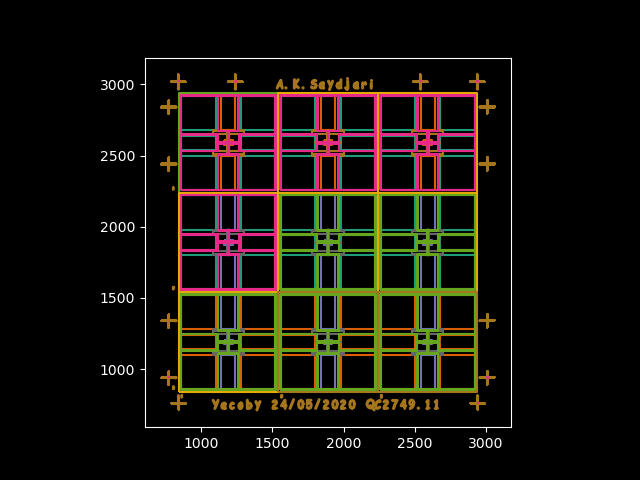

In [29]:
# Plotting
df = gpd.read_file(outFileName)
ax = df.plot(column='Layer', cmap='Dark2')
ax.set_facecolor((0, 0, 0))

# Boolean Builder

## User Defined

In [17]:
inputFilename = 'BooleanTest.dxf'

layer1 = 'a'
layer2 = 'b'
targetLayer = 'c'
operation = 'AND'

outputFilename = '{}_bool.dxf'.format(os.path.splitext(inputFilename)[0])

## Helper Functions

In [18]:
def importDXFtoGPDwPolygons(fileName):
    df = gpd.read_file(fileName)
    df1 = df[df['SubClasses'] == 'AcDbEntity:AcDbPolyline']
    df2 = df1.copy()
    df2['geometry'] = df1['geometry'].apply(lambda x: Polygon(x.coords))
    return df2
def exportGPDwPolygonstoDXF(df):
    df1 = df.copy()
    df1['geometry'] = df['geometry'].apply(lambda x: LineString(x.exterior.coords))
    return df1
def relabelPostBoolGen(df,targetLayer):
    if 'Layer' in df.columns:
        df.loc[:,'Layer'] = targetLayer
        out = df
    else:
        dfb_out = df[df.isnull()['Layer_1']].copy()
        if not dfb_out.empty:
            dfb_out.loc[:,'Layer'] = targetLayer
            cols = dfb_out.columns.tolist() 
            cols = cols[-1:] + cols[7:-2] + cols[-2:-1]
            dfb_out1 = dfb_out[cols]
            dfb_out2 = dfb_out1.rename(columns = {x: x.split('_')[0] for x in cols[1:-1]})
        else:
            dfb_out2 = gpd.GeoDataFrame([])

        dfa_out = df[df.notnull()['Layer_1']].copy()
        dfa_out.loc[:,'Layer'] = targetLayer
        cols = dfa_out.columns.tolist() 
        cols = cols[-1:] + cols[1:6] + cols[-2:-1]
        dfa_out1 = dfa_out[cols]
        dfa_out2 = dfa_out1.rename(columns = {x: x.split('_')[0] for x in cols[1:-1]})
        out = dfa_out2.append(dfb_out2)
    return out
def reMergePostBool(filename,boolOut):
    df = importDXFtoGPDwPolygons(filename)
    hexList = list(df['EntityHandle'])
    maxHex = max([int(x,16) for x in hexList])
    newHexlist = [format(x,'02X') for x in range(maxHex+1,maxHex+boolOut.shape[0]+1)]
    relabelBool = boolOut.assign(EntityHandle=newHexlist)
    return df.append(relabelBool)
def boolGeneric(filename,layer1,layer2, boolOp):
    df = importDXFtoGPDwPolygons(filename)
    dfa = df[df['Layer'] == layer1]
    dfb = df[df['Layer'] == layer2]
    return gpd.GeoDataFrame(gpd.overlay(dfa, dfb, how=boolDict[boolOp]))
def resaveWLayerColor(fileName, layerDict):
    doc = ezdxf.readfile(fileName)
    modelspace = doc.modelspace()
    for layer in doc.layers:
        if layer.dxf.name in layerDict:
            layer.color = layerDict[layer.dxf.name]
    doc.saveas('{}_c.dxf'.format(os.path.splitext(fileName)[0]))
def getLayerDic(doc):
    layers = doc.layers
    return {lay.dxf.name: lay.color for lay in layers}

In [19]:
boolDict = {
    'AND': 'intersection',
    'OR': 'union',
    'XOR': 'symmetric_difference',
    'MINUS': 'difference',
    'CUT': 'identity'
}

## Main

In [20]:
doc = ezdxf.readfile(inputFilename)
layerDict = getLayerDic(doc)
boolOut = boolGeneric(inputFilename,layer1,layer2,operation)
labelOut = relabelPostBoolGen(boolOut,targetLayer)
reMergeOut = reMergePostBool(inputFilename,labelOut)
exportGPDwPolygonstoDXF(reMergeOut).to_file(outputFilename, driver='DXF')
resaveWLayerColor(outputFilename, layerDict)

<IPython.core.display.Javascript object>


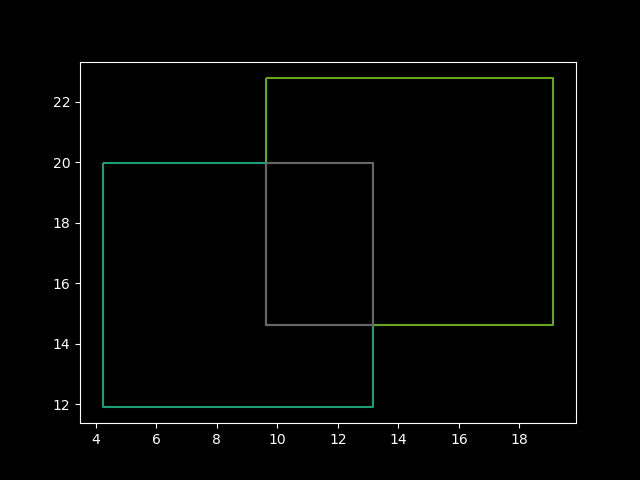

In [30]:
# Plotting
df = gpd.read_file('{}_c.dxf'.format(os.path.splitext(outputFilename)[0]))
ax = df.plot(column='Layer', cmap='Dark2')
ax.set_facecolor((0, 0, 0))